In [1]:
from typing import Callable, List

import tensorflow as tf
import tensorflow_datasets as tfds
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import Tensor

import imageio
from IPython.display import display, Image

2023-12-08 01:55:38.675962: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 01:55:38.676021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 01:55:38.768207: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 01:55:38.958695: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 01:55:40.092064: W tensorflow/compiler/tf2

# Data aquisition&preparation

In [ ]:
# # Oxford-IIIT pet dataset: https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet
# dataset_name = "oxford_iiit_pet"  # dataset name
# split = [
#     "train[:80%]+test[:80%]",
#     "train[80%:]+test[80%:]",
# ]  # train-validation split

In [2]:
# Oxford Flowers 102 dataset: https://www.tensorflow.org/datasets/catalog/oxford_flowers102
dataset_name = "oxford_flowers102"  # dataset name
split = [
    "train[:80%]+validation[:80%]+test[:80%]",
    "train[80%:]+validation[80%:]+test[80%:]",
]  # train-validation split

In [3]:
# Hyperparameters
IMAGE_SIZE = 64  # resized image size
BATCH_SIZE = 32  # batch size
TIMESTEPS = 500  # number of timesteps (noise levels)

LEARNING_RATE = 2e-4    # learning rate
EPOCHS = 1000           # number of epochs

MIN_BETA = 1e-4  # minimum beta
MAX_BETA = 0.02  # maximum beta

ACTIVATION = tf.keras.activations.swish  # activation function
UNET_FILTERS = [64, 128, 256, 512]       # U-Net filter sizes
NUM_RES_BLOCKS = 2                       # number of residual blocks in each U-Net level
NUM_GROUPS = 8                           # number of groups for group normalization
EMA_RATE = 0.999                         # exponential moving average rate

KID_IMAGE_SIZE = 75
KID_DIFF_STEPS = 5

In [4]:
# preprocess an image
def preprocess_image(data):
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)  # find the smallest dimension
    img = tf.image.crop_to_bounding_box(  # crop the image to a square
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )
    img = tf.cast(img, dtype=tf.float32)  # cast the image to float32
    img = tf.image.resize(img, size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True)  # resize the image to img_size x img_size
    return tf.clip_by_value(img * 2.0 / 255.0 - 1.0, -1.0, 1.0)  # normalize the image to [-1, 1]


def reverse_transform(img, cast_int=True):
    transformed = tf.clip_by_value((img + 1.0) / 2.0 * 255.0, 0.0, 255.0)  # reverse the normalization
    return transformed.numpy().astype(np.uint8) if cast_int else transformed

def augment_image(img):
    return tf.image.random_flip_left_right(img) # flip the image horizontally with 50% probability

In [5]:
# preprocess a dataset
def preprocess_dataset(dataset, augment=False):
    ds = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # preprocess images
    if augment:
        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) # augment the dataset if needed
    return (
        ds.batch(BATCH_SIZE, drop_remainder=True)  # organize the dataset into batches
        .shuffle(2 * BATCH_SIZE)  # shuffle the dataset
        .prefetch(buffer_size=tf.data.AUTOTUNE)  # prefetch data for better performance
    )


# load dataset from tensorflow datasets with the given name
def load_data(dataset_name):
    train_ds, val_ds = tfds.load(dataset_name, split=split, shuffle_files=True)  # load the dataset
    train_ds = preprocess_dataset(train_ds, True) # preprocess the training dataset with augmentation
    val_ds = preprocess_dataset(val_ds)  # preprocess the validation dataset
    return train_ds, val_ds

In [6]:
train_ds, val_ds = load_data(dataset_name) # load, split and preprocess the dataset

2023-12-08 01:58:39.247254: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 01:58:40.055040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 01:58:40.055095: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 01:58:40.057346: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 01:58:40.057442: I external/local_xla/xla/stream_executor

In [7]:
def show(img): # display an image
    plt.figure(figsize=(3, 3))
    plt.imshow(reverse_transform(img)) # reverse the normalization and display the image
    plt.axis("off")
    plt.show()


def plot(imgs): # display a list of images in a row
    _, axs = plt.subplots(figsize=(len(imgs) * 2, 2), ncols=len(imgs), nrows=1) # create subplots
    for idx, img in enumerate(imgs):
        axs[idx].imshow(reverse_transform(img))
        axs[idx].axis("off")
    plt.tight_layout()

2023-12-08 01:58:46.550069: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


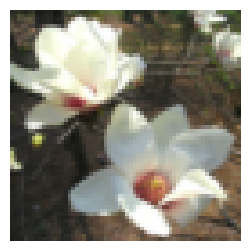

In [8]:
demo_img = next(iter(train_ds.unbatch().take(1)))
show(demo_img)

## Diffusion utility

In [9]:
class Diffusion: # diffusion utilities
    def __init__(self, timesteps, min_beta, max_beta):
        self.timesteps = timesteps  # number of timesteps (noise levels)
        self.min_beta = min_beta  # first beta
        self.max_beta = max_beta  # last beta

        self.betas = tf.linspace(min_beta, max_beta, timesteps)  # setting schedule for beta (linear schedule)
        self.alphas = 1 - self.betas  # alpha_t = 1 - beta_t
        self.alphas_cum_prod = tf.math.cumprod(self.alphas)  # cumulative product of alphas
        self.alphas_cum_prod_prev = tf.concat([[1.0], self.alphas_cum_prod[:-1]], axis=0)  # cumulative product of alphas shifted
        self.recip_sqrt_alphas = tf.math.sqrt(1.0 / self.alphas)  # reciprocals of square roots of alphas
        self.sqrt_alphas_prod = tf.math.sqrt(self.alphas_cum_prod)  # square roots of cumulative product of alphas
        self.sqrt_one_minus_alphas_prod = tf.math.sqrt(1.0 - self.alphas_cum_prod)  # square roots of 1 - cumulative product of alphas

        self.posterior_variance = self.betas * (1.0 - self.alphas_cum_prod_prev) / (1.0 - self.alphas_cum_prod) # posterior variance (Equation 6, 7)

    def extract(self, series, t, x_shape): # extract the corresponding values from a data series for given timesteps
        out = tf.gather(series, t)
        return tf.reshape(out, [x_shape[0], 1, 1, 1])

    def q_sample(self, x_start, t, noise=None): # forward diffusion starting from x_start and applying t timesteps of noise
        x_start_shape = tf.shape(x_start)
        if noise is None:
            noise = tf.random.normal(x_start_shape, dtype=x_start.dtype) # use Gaussian noise if not provided

        sqrt_alphas_prod_t = self.extract(self.sqrt_alphas_prod, t, x_start_shape)
        sqrt_one_minus_alphas_prod_t = self.extract(self.sqrt_one_minus_alphas_prod, t, x_start_shape)
        return sqrt_alphas_prod_t * x_start + sqrt_one_minus_alphas_prod_t * noise  # Equation 12

    def p_sample_step(self, model, x, t, t_index): # denoise one step
        x_shape = tf.shape(x)
        beta_t = self.extract(self.betas, t, x_shape)
        sqrt_one_minus_alphas_prod_t = self.extract(self.sqrt_one_minus_alphas_prod, t, x_shape)
        recip_sqrt_alphas_t = self.extract(self.recip_sqrt_alphas, t, x_shape)
        noise_pred = model([x, t], training=False) # predict noise at current timestep
        model_mean = recip_sqrt_alphas_t * (x - noise_pred * beta_t / sqrt_one_minus_alphas_prod_t)  # Equation 11

        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = self.extract(self.posterior_variance, t, x_shape)
            noise = tf.random.normal(x_shape, dtype=x.dtype)  # sample noise from N(0, I)
            return model_mean + tf.math.sqrt(posterior_variance_t) * noise  # Algorithm 2, Line 4

    def p_sample_full(self, model, shape, img=None, timesteps=None): # complete denoising process
        if timesteps is None:
            timesteps = self.timesteps # use the maximum timesteps if not provided
        if img is None:
            img = tf.random.normal(shape, dtype=tf.float32)  # pure noise initially
        imgs = [img] # collect denoised images at each timestep
        for t in reversed(range(timesteps)):
            t = t * self.timesteps // timesteps
            t_batch = tf.cast(tf.fill((shape[0],), t), dtype=tf.int64)
            img = self.p_sample_step(model, img, t_batch, t) # denoise one step
            imgs.append(img)
        return imgs

    def generate_images(self, model, num_images=16, image_size=IMAGE_SIZE, timesteps=None): # generate multiple images
        return self.p_sample_full(model, (num_images, image_size, image_size, 3), timesteps=timesteps)

In [10]:
diffusion = Diffusion(
    timesteps=TIMESTEPS,
    min_beta=MIN_BETA,
    max_beta=MAX_BETA,
) # create a diffusion utility

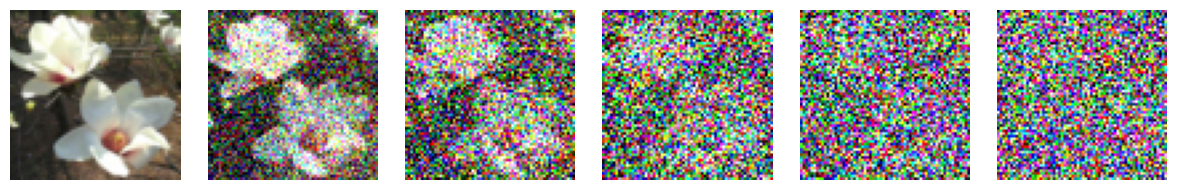

In [11]:
# demonstrate the noising process
noisy_images = [
    tf.squeeze(diffusion.q_sample(tf.expand_dims(demo_img, 0), tf.constant([t])))
    for t in [0, 100, 200, 300, 400, 499]
]
plot(noisy_images)

## Neural network

U-net

In [12]:
# sinusoidal time embedding
def time_embedding(dim: int):
    def apply(inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        half_dim = dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = inputs[:,None] * emb[None,:]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb

    return apply


# residual block with 2 convolutional layers and group normalization 
def residual_block(filters: int, groups: int, activation_fn) -> Callable[[List[Tensor]], Tensor]:
    def apply(inputs: List[Tensor]) -> Tensor:
        x, t = inputs
        # store residual connection
        if filters == x.shape[3]:
            residual = x
        else:
            residual = tf.keras.layers.Conv2D(filters, (1, 1))(x)

        # activate and arrange time data
        t = activation_fn(t)
        t = tf.keras.layers.Dense(filters)(t)[:,None,None,:]

        # first group normalization
        if x.shape[3] >= groups:
            x = tf.keras.layers.GroupNormalization(groups=groups)(x)
            x = activation_fn(x)

        # first convolution
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation=tf.keras.activations.swish, padding="same", )(x)

        # add time data to other features, apply group normalization and activation
        x = tf.keras.layers.Add()([x, t])
        x = tf.keras.layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)

        # second convolution
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation=tf.keras.activations.swish, padding="same", )(x)

        # add residual connection
        x = tf.keras.layers.Add()([x, residual])
        return x

    return apply


# create a U-Net with the given filter sizes
def create_u_net(filters: List[int], num_res_blocks: int, num_groups: int, activation_fn) -> tf.keras.Model:
    # input layers: image, time
    image_input = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    time_input = tf.keras.layers.Input(shape=(), dtype=tf.int64)

    x = image_input
    t = time_embedding(filters[0]*4)(time_input) # embed time data
    skip_connections = [] # list to store skip connections

    # down sampling
    for f in filters:
        # add multiple residual blocks
        for _ in range(num_res_blocks):
            x = residual_block(f, num_groups, activation_fn)([x, t])
            if f != filters[-1]:
                # storing layer outputs for skip connections
                skip_connections.append(x)

        if f != filters[-1]:
            # max pooling
            x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # up sampling
    for f in reversed(filters[:-1]):
        # up sampling + convolution
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        x = tf.keras.layers.Conv2D(f, (3, 3), padding="same")(x)
        # multiple residual blocks
        for _ in range(num_res_blocks):
            # concatenate skip connection
            x = tf.keras.layers.Concatenate()([x, skip_connections.pop()])
            # residual block
            x = residual_block(f, num_groups, activation_fn)([x, t])

    # output layer with no activation
    output_layer = tf.keras.layers.Conv2D(3, (1, 1), kernel_initializer="zeros")(x)
    # create model with input and output layers
    u_net = tf.keras.Model([image_input, time_input], output_layer)
    return u_net


network = create_u_net(UNET_FILTERS, NUM_RES_BLOCKS, NUM_GROUPS, ACTIVATION) # train network
ema_network = create_u_net(UNET_FILTERS, NUM_RES_BLOCKS, NUM_GROUPS, ACTIVATION) # exponential moving average network
ema_network.set_weights(network.get_weights()) # initialize EMA network with the same weights

## Kernel Inception Distance

In [13]:
class KID(tf.keras.metrics.Metric, tf.keras.callbacks.Callback):
    def __init__(self, val_ds, kid_image_size=KID_IMAGE_SIZE, period=10):
        super(KID, self).__init__()

        self.tracker = tf.keras.metrics.Mean()
        self.calculate = True
        self.epoch = 0
        self.period = period
        self.encoder = tf.keras.Sequential([
            tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
            tf.keras.layers.Lambda(lambda img: reverse_transform(img, cast_int=False)),
            tf.keras.layers.Resizing(height=kid_image_size, width=kid_image_size),
            tf.keras.layers.Lambda(tf.keras.applications.inception_v3.preprocess_input),
            tf.keras.applications.InceptionV3(
                include_top=False,
                input_shape=(kid_image_size, kid_image_size, 3),
                weights="imagenet",
            ),
            tf.keras.layers.GlobalAveragePooling2D(),
        ])
        self.originals_features = [self.encoder(original, training=False) for original in val_ds]
        self.batch_size = tf.shape(self.originals_features[0])[0]
        batch_size_f = tf.cast(self.batch_size, dtype=tf.float32)
        self.mean = lambda kernel: tf.reduce_sum(kernel * (1.0 - tf.eye(self.batch_size))) / (batch_size_f * (batch_size_f - 1.0))

    def get_kernel(self, features_1, features_2):
        feature_dims = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dims + 1.0) ** 3.0

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch + 1
        if self.epoch % self.period == 0:
            self.calculate = True

    def update_state(self):
        generated_images = self.model.generate_images(self.batch_size)
        generated_features = self.encoder(generated_images, training=False)
        generated_kernel_mean = self.mean(self.get_kernel(generated_features, generated_features))

        self.tracker.reset_state()
        for original_features in self.originals_features:
            original_kernel_mean = self.mean(self.get_kernel(original_features, original_features))
            cross_kernel_mean = self.mean(self.get_kernel(original_features, generated_features))
            batch_score = original_kernel_mean + generated_kernel_mean - 2.0 * cross_kernel_mean
            self.tracker.update_state(batch_score)

        self.calculate = False

    def reset_state(self):
        pass

    def result(self):
        if self.calculate:
            self.update_state()
        return self.tracker.result()

kid = KID(val_ds, KID_IMAGE_SIZE, period=10)

2023-12-08 01:59:08.250142: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-08 01:59:09.083708: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


## Diffusion Model

In [14]:
class DiffusionModel(tf.keras.Model): # diffusion model that performs training based on the diffusion process
    def __init__(self, diffusion, net, ema_net, ema_rate, kid):
        super().__init__()
        self.diffusion = diffusion # diffusion utility
        self.network = net # U-net
        self.ema_network = ema_net # EMA U-net
        self.ema_rate = ema_rate # EMA rate
        self.kid = kid # KID utility

    def call(self, Xs, training=None, mask=None): # functional interface
        if training:
            return self.network(Xs) # use the base network during training
        return self.ema_network(Xs) # use the EMA network otherwise

    def random_t(self, Xs): # sample a batch of random timestep uniformally from [0, T] 
        result = tf.random.uniform(
            (tf.shape(Xs)[0],),
            minval=0,
            maxval=self.diffusion.timesteps,
            dtype=tf.int64, # use int64 for more precision
        )
        return result

    def step(self, Xs, t, training=True):
        noise = tf.random.normal(tf.shape(Xs), dtype=Xs.dtype) # sample a batch of noise from N(0, I)
        Xs_noisy = self.diffusion.q_sample(Xs, t, noise) # apply t timesteps of noise to Xs
        if training:
            noise_pred = self.network([Xs_noisy, t], training=training) # predict noise at current timestep with the base network
        else:
            noise_pred = self.ema_network([Xs_noisy, t], training=training) # predict noise at current timestep with the EMA network
        return self.loss(noise, noise_pred) # calculate loss between predicted noise and sampled noise

    def train_step(self, Xs):
        t = self.random_t(Xs) # sample random timesteps
        with tf.GradientTape() as tape:
            loss = self.step(Xs, t, training=True) # calculate loss for a denoise step
        grads = tape.gradient(loss, self.network.trainable_weights) # get gradients
        self.optimizer.apply_gradients(zip(grads, self.network.trainable_weights)) # backpropagate
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema_rate * ema_weight + (1 - self.ema_rate) * weight) # update EMA weights with exponential moving average
        return {"loss": loss}

    def test_step(self, Xs):
        t = self.random_t(Xs)
        loss = self.step(Xs, t, training=False)

        return {"loss": loss, "kid": self.kid.result()}

    def generate_images(self, count):
        return self.diffusion.generate_images(self, count)[-1]

In [15]:
model = DiffusionModel(diffusion, network, ema_network, EMA_RATE, kid) # create a diffusion model

In [16]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE),
)

In [17]:
best_loss_model_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="unet_loss.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
)

best_kid_model_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="unet_kid.h5",
    monitor="val_kid",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[best_loss_model_cb, best_kid_model_cb, kid],
    verbose=2,
)

Epoch 1/1000


2023-12-08 02:00:02.594769: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6f415c4e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-08 02:00:02.594806: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-12-08 02:00:02.613055: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701997202.712707     637 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


204/204 - 287s - loss: 0.0834 - val_loss: 0.9412 - val_kid: 1.9141 - 287s/epoch - 1s/step
Epoch 2/1000
204/204 - 115s - loss: 0.0650 - val_loss: 0.8300 - val_kid: 1.9141 - 115s/epoch - 565ms/step
Epoch 3/1000
204/204 - 116s - loss: 0.0546 - val_loss: 0.6506 - val_kid: 1.9141 - 116s/epoch - 569ms/step
Epoch 4/1000
204/204 - 114s - loss: 0.0776 - val_loss: 0.5015 - val_kid: 1.9141 - 114s/epoch - 561ms/step
Epoch 5/1000
204/204 - 114s - loss: 0.1395 - val_loss: 0.3795 - val_kid: 1.9141 - 114s/epoch - 561ms/step
Epoch 6/1000
204/204 - 114s - loss: 0.0492 - val_loss: 0.2395 - val_kid: 1.9141 - 114s/epoch - 557ms/step
Epoch 7/1000
204/204 - 114s - loss: 0.0202 - val_loss: 0.1840 - val_kid: 1.9141 - 114s/epoch - 560ms/step
Epoch 8/1000
204/204 - 114s - loss: 0.0956 - val_loss: 0.1610 - val_kid: 1.9141 - 114s/epoch - 560ms/step
Epoch 9/1000
204/204 - 114s - loss: 0.0477 - val_loss: 0.1153 - val_kid: 1.9141 - 114s/epoch - 560ms/step
Epoch 10/1000


2023-12-08 02:23:39.567120: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 249s - loss: 0.0569 - val_loss: 0.0923 - val_kid: 1.0422 - 249s/epoch - 1s/step
Epoch 11/1000


2023-12-08 02:23:49.524179: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0427 - val_loss: 0.0613 - val_kid: 1.0422 - 115s/epoch - 562ms/step
Epoch 12/1000
204/204 - 114s - loss: 0.0565 - val_loss: 0.0772 - val_kid: 1.0422 - 114s/epoch - 559ms/step
Epoch 13/1000


2023-12-08 02:29:22.859246: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0486 - val_loss: 0.0563 - val_kid: 1.0422 - 114s/epoch - 560ms/step
Epoch 14/1000
204/204 - 115s - loss: 0.0360 - val_loss: 0.0448 - val_kid: 1.0422 - 115s/epoch - 562ms/step
Epoch 15/1000


2023-12-08 02:31:27.152736: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0692 - val_loss: 0.0595 - val_kid: 1.0422 - 114s/epoch - 558ms/step
Epoch 16/1000


2023-12-08 02:33:21.127363: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0388 - val_loss: 0.0582 - val_kid: 1.0422 - 114s/epoch - 560ms/step
Epoch 17/1000
204/204 - 114s - loss: 0.0551 - val_loss: 0.0345 - val_kid: 1.0422 - 114s/epoch - 560ms/step
Epoch 18/1000
204/204 - 114s - loss: 0.0642 - val_loss: 0.0530 - val_kid: 1.0422 - 114s/epoch - 558ms/step
Epoch 19/1000


2023-12-08 02:39:03.216533: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 02:40:47.994820: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0526 - val_loss: 0.0528 - val_kid: 1.0422 - 114s/epoch - 559ms/step
Epoch 20/1000


2023-12-08 02:40:57.281343: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 242s - loss: 0.0576 - val_loss: 0.0581 - val_kid: 0.8025 - 242s/epoch - 1s/step
Epoch 21/1000
204/204 - 114s - loss: 0.0566 - val_loss: 0.0397 - val_kid: 0.8025 - 114s/epoch - 559ms/step
Epoch 22/1000
204/204 - 114s - loss: 0.0412 - val_loss: 0.0545 - val_kid: 0.8025 - 114s/epoch - 558ms/step
Epoch 23/1000
204/204 - 114s - loss: 0.0324 - val_loss: 0.0403 - val_kid: 0.8025 - 114s/epoch - 559ms/step
Epoch 24/1000
204/204 - 114s - loss: 0.0357 - val_loss: 0.0445 - val_kid: 0.8025 - 114s/epoch - 560ms/step
Epoch 25/1000
204/204 - 114s - loss: 0.0750 - val_loss: 0.0489 - val_kid: 0.8025 - 114s/epoch - 559ms/step
Epoch 26/1000
204/204 - 114s - loss: 0.0448 - val_loss: 0.0675 - val_kid: 0.8025 - 114s/epoch - 558ms/step
Epoch 27/1000
204/204 - 114s - loss: 0.0547 - val_loss: 0.0364 - val_kid: 0.8025 - 114s/epoch - 558ms/step
Epoch 28/1000
204/204 - 115s - loss: 0.0365 - val_loss: 0.0283 - val_kid: 0.8025 - 115s/epoch - 561ms/step
Epoch 29/1000
204/204 - 114s - loss: 0.0433 - val_loss

2023-12-08 03:10:00.409820: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0744 - val_loss: 0.0421 - val_kid: 0.6064 - 114s/epoch - 558ms/step
Epoch 34/1000


2023-12-08 03:13:38.267507: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0565 - val_loss: 0.0528 - val_kid: 0.6064 - 114s/epoch - 557ms/step
Epoch 35/1000


2023-12-08 03:15:32.143891: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0561 - val_loss: 0.0422 - val_kid: 0.6064 - 114s/epoch - 558ms/step
Epoch 36/1000
204/204 - 114s - loss: 0.0292 - val_loss: 0.0399 - val_kid: 0.6064 - 114s/epoch - 558ms/step
Epoch 37/1000


2023-12-08 03:19:19.819343: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0559 - val_loss: 0.0459 - val_kid: 0.6064 - 114s/epoch - 558ms/step
Epoch 38/1000
204/204 - 114s - loss: 0.0450 - val_loss: 0.0382 - val_kid: 0.6064 - 114s/epoch - 558ms/step
Epoch 39/1000


2023-12-08 03:21:22.798019: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0669 - val_loss: 0.0413 - val_kid: 0.6064 - 114s/epoch - 558ms/step
Epoch 40/1000
204/204 - 241s - loss: 0.0476 - val_loss: 0.0560 - val_kid: 0.5801 - 241s/epoch - 1s/step
Epoch 41/1000
204/204 - 114s - loss: 0.0251 - val_loss: 0.0369 - val_kid: 0.5801 - 114s/epoch - 559ms/step
Epoch 42/1000
204/204 - 114s - loss: 0.0433 - val_loss: 0.0503 - val_kid: 0.5801 - 114s/epoch - 560ms/step
Epoch 43/1000
204/204 - 114s - loss: 0.0242 - val_loss: 0.0364 - val_kid: 0.5801 - 114s/epoch - 559ms/step
Epoch 44/1000
204/204 - 114s - loss: 0.0335 - val_loss: 0.0441 - val_kid: 0.5801 - 114s/epoch - 559ms/step
Epoch 45/1000


2023-12-08 03:34:53.987660: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0268 - val_loss: 0.0417 - val_kid: 0.5801 - 114s/epoch - 559ms/step
Epoch 46/1000


2023-12-08 03:38:32.532203: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0276 - val_loss: 0.0614 - val_kid: 0.5801 - 114s/epoch - 558ms/step
Epoch 47/1000
204/204 - 114s - loss: 0.0269 - val_loss: 0.0572 - val_kid: 0.5801 - 114s/epoch - 558ms/step
Epoch 48/1000
204/204 - 114s - loss: 0.0361 - val_loss: 0.0397 - val_kid: 0.5801 - 114s/epoch - 559ms/step
Epoch 49/1000
204/204 - 114s - loss: 0.0388 - val_loss: 0.0393 - val_kid: 0.5801 - 114s/epoch - 559ms/step
Epoch 50/1000


2023-12-08 03:44:23.818126: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 03:48:15.765256: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 242s - loss: 0.0303 - val_loss: 0.0316 - val_kid: 0.4459 - 242s/epoch - 1s/step
Epoch 51/1000


2023-12-08 03:50:10.182699: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0449 - val_loss: 0.0417 - val_kid: 0.4459 - 114s/epoch - 559ms/step
Epoch 52/1000


2023-12-08 03:52:04.368071: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0273 - val_loss: 0.0311 - val_kid: 0.4459 - 114s/epoch - 559ms/step
Epoch 53/1000


2023-12-08 03:53:58.760773: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0743 - val_loss: 0.0352 - val_kid: 0.4459 - 114s/epoch - 561ms/step
Epoch 54/1000
204/204 - 114s - loss: 0.0645 - val_loss: 0.0178 - val_kid: 0.4459 - 114s/epoch - 560ms/step
Epoch 55/1000


2023-12-08 03:57:46.806102: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0616 - val_loss: 0.0436 - val_kid: 0.4459 - 114s/epoch - 558ms/step
Epoch 56/1000


2023-12-08 04:00:08.993225: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0499 - val_loss: 0.0357 - val_kid: 0.4459 - 114s/epoch - 560ms/step
Epoch 57/1000


2023-12-08 04:00:18.200990: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 04:02:03.107544: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0266 - val_loss: 0.0365 - val_kid: 0.4459 - 114s/epoch - 559ms/step
Epoch 58/1000


2023-12-08 04:02:12.273675: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0429 - val_loss: 0.0187 - val_kid: 0.4459 - 114s/epoch - 559ms/step
Epoch 59/1000


2023-12-08 04:04:06.221248: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 04:05:51.064221: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0289 - val_loss: 0.0570 - val_kid: 0.4459 - 114s/epoch - 559ms/step
Epoch 60/1000


2023-12-08 04:09:52.774288: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 242s - loss: 0.0391 - val_loss: 0.0410 - val_kid: 0.4109 - 242s/epoch - 1s/step
Epoch 61/1000
204/204 - 114s - loss: 0.0446 - val_loss: 0.0620 - val_kid: 0.4109 - 114s/epoch - 558ms/step
Epoch 62/1000


2023-12-08 04:13:40.735820: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0785 - val_loss: 0.0320 - val_kid: 0.4109 - 114s/epoch - 557ms/step
Epoch 63/1000


2023-12-08 04:13:49.875643: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0446 - val_loss: 0.0528 - val_kid: 0.4109 - 114s/epoch - 557ms/step
Epoch 64/1000


2023-12-08 04:15:43.508164: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 04:17:28.639491: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0572 - val_loss: 0.0766 - val_kid: 0.4109 - 114s/epoch - 560ms/step
Epoch 65/1000
204/204 - 114s - loss: 0.0551 - val_loss: 0.0478 - val_kid: 0.4109 - 114s/epoch - 558ms/step
Epoch 66/1000


2023-12-08 04:19:31.558581: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 04:21:16.533400: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0219 - val_loss: 0.0233 - val_kid: 0.4109 - 114s/epoch - 560ms/step
Epoch 67/1000
204/204 - 114s - loss: 0.0343 - val_loss: 0.0802 - val_kid: 0.4109 - 114s/epoch - 558ms/step
Epoch 68/1000


2023-12-08 04:23:19.611090: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0510 - val_loss: 0.0581 - val_kid: 0.4109 - 114s/epoch - 558ms/step
Epoch 69/1000


2023-12-08 04:26:58.062930: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0463 - val_loss: 0.0556 - val_kid: 0.4109 - 114s/epoch - 558ms/step
Epoch 70/1000


2023-12-08 04:27:08.239837: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 247s - loss: 0.0384 - val_loss: 0.0830 - val_kid: 0.3565 - 247s/epoch - 1s/step
Epoch 71/1000
204/204 - 114s - loss: 0.0391 - val_loss: 0.0407 - val_kid: 0.3565 - 114s/epoch - 558ms/step
Epoch 72/1000


2023-12-08 04:33:08.341956: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0270 - val_loss: 0.0507 - val_kid: 0.3565 - 114s/epoch - 559ms/step
Epoch 73/1000
204/204 - 114s - loss: 0.0216 - val_loss: 0.0234 - val_kid: 0.3565 - 114s/epoch - 558ms/step
Epoch 74/1000
204/204 - 114s - loss: 0.0520 - val_loss: 0.0673 - val_kid: 0.3565 - 114s/epoch - 558ms/step
Epoch 75/1000
204/204 - 114s - loss: 0.0318 - val_loss: 0.0432 - val_kid: 0.3565 - 114s/epoch - 558ms/step
Epoch 76/1000


2023-12-08 04:40:43.915554: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 04:42:28.752802: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0575 - val_loss: 0.0646 - val_kid: 0.3565 - 114s/epoch - 559ms/step
Epoch 77/1000


2023-12-08 04:42:37.982523: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0331 - val_loss: 0.0467 - val_kid: 0.3565 - 114s/epoch - 558ms/step
Epoch 78/1000


2023-12-08 04:46:16.731725: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2057984 bytes after encountering the first element of size 2057984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0370 - val_loss: 0.0530 - val_kid: 0.3565 - 114s/epoch - 559ms/step
Epoch 79/1000
204/204 - 114s - loss: 0.0427 - val_loss: 0.0359 - val_kid: 0.3565 - 114s/epoch - 558ms/step
Epoch 80/1000


2023-12-08 04:48:19.838955: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 244s - loss: 0.0519 - val_loss: 0.0565 - val_kid: 0.3966 - 244s/epoch - 1s/step
Epoch 81/1000


2023-12-08 04:54:08.887717: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0417 - val_loss: 0.0427 - val_kid: 0.3966 - 114s/epoch - 560ms/step
Epoch 82/1000


2023-12-08 04:56:02.632126: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0491 - val_loss: 0.0437 - val_kid: 0.3966 - 114s/epoch - 557ms/step
Epoch 83/1000


2023-12-08 04:56:11.791045: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0402 - val_loss: 0.0222 - val_kid: 0.3966 - 114s/epoch - 558ms/step
Epoch 84/1000


2023-12-08 04:58:05.672687: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2057984 bytes after encountering the first element of size 2057984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0296 - val_loss: 0.0342 - val_kid: 0.3966 - 114s/epoch - 558ms/step
Epoch 85/1000


2023-12-08 04:59:59.465643: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 05:01:44.702833: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0378 - val_loss: 0.0394 - val_kid: 0.3966 - 114s/epoch - 561ms/step
Epoch 86/1000


2023-12-08 05:01:53.851617: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0337 - val_loss: 0.0286 - val_kid: 0.3966 - 114s/epoch - 558ms/step
Epoch 87/1000
204/204 - 114s - loss: 0.0521 - val_loss: 0.0502 - val_kid: 0.3966 - 114s/epoch - 558ms/step
Epoch 88/1000


2023-12-08 05:05:41.501569: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0398 - val_loss: 0.0292 - val_kid: 0.3966 - 114s/epoch - 559ms/step
Epoch 89/1000
204/204 - 114s - loss: 0.0311 - val_loss: 0.0278 - val_kid: 0.3966 - 114s/epoch - 558ms/step
Epoch 90/1000


2023-12-08 05:09:29.271599: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 05:13:19.064013: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 239s - loss: 0.0231 - val_loss: 0.0181 - val_kid: 0.3743 - 239s/epoch - 1s/step
Epoch 91/1000


2023-12-08 05:13:28.229229: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0514 - val_loss: 0.0327 - val_kid: 0.3743 - 114s/epoch - 558ms/step
Epoch 92/1000


2023-12-08 05:17:06.790688: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0402 - val_loss: 0.0342 - val_kid: 0.3743 - 114s/epoch - 558ms/step
Epoch 93/1000


2023-12-08 05:17:15.985241: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0208 - val_loss: 0.0414 - val_kid: 0.3743 - 114s/epoch - 559ms/step
Epoch 94/1000


2023-12-08 05:19:10.926610: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0266 - val_loss: 0.0696 - val_kid: 0.3743 - 114s/epoch - 559ms/step
Epoch 95/1000
204/204 - 114s - loss: 0.0218 - val_loss: 0.0419 - val_kid: 0.3743 - 114s/epoch - 557ms/step
Epoch 96/1000
204/204 - 114s - loss: 0.0355 - val_loss: 0.0222 - val_kid: 0.3743 - 114s/epoch - 559ms/step
Epoch 97/1000
204/204 - 114s - loss: 0.0418 - val_loss: 0.0384 - val_kid: 0.3743 - 114s/epoch - 558ms/step
Epoch 98/1000


2023-12-08 05:26:45.507902: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0436 - val_loss: 0.0575 - val_kid: 0.3743 - 114s/epoch - 558ms/step
Epoch 99/1000
204/204 - 114s - loss: 0.0389 - val_loss: 0.0205 - val_kid: 0.3743 - 114s/epoch - 558ms/step
Epoch 100/1000
204/204 - 239s - loss: 0.0268 - val_loss: 0.0476 - val_kid: 0.3809 - 239s/epoch - 1s/step
Epoch 101/1000


2023-12-08 05:36:16.538785: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0434 - val_loss: 0.0434 - val_kid: 0.3809 - 114s/epoch - 559ms/step
Epoch 102/1000
204/204 - 114s - loss: 0.0434 - val_loss: 0.0366 - val_kid: 0.3809 - 114s/epoch - 558ms/step
Epoch 103/1000
204/204 - 114s - loss: 0.0630 - val_loss: 0.0437 - val_kid: 0.3809 - 114s/epoch - 558ms/step
Epoch 104/1000


2023-12-08 05:41:58.213532: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0575 - val_loss: 0.0741 - val_kid: 0.3809 - 114s/epoch - 559ms/step
Epoch 105/1000


2023-12-08 05:42:07.371352: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0271 - val_loss: 0.0418 - val_kid: 0.3809 - 114s/epoch - 559ms/step
Epoch 106/1000


2023-12-08 05:45:45.990650: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0405 - val_loss: 0.0239 - val_kid: 0.3809 - 114s/epoch - 558ms/step
Epoch 107/1000


2023-12-08 05:45:55.132976: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0404 - val_loss: 0.0516 - val_kid: 0.3809 - 114s/epoch - 558ms/step
Epoch 108/1000


2023-12-08 05:49:33.745532: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0319 - val_loss: 0.0331 - val_kid: 0.3809 - 114s/epoch - 558ms/step
Epoch 109/1000


2023-12-08 05:49:42.861702: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0353 - val_loss: 0.0456 - val_kid: 0.3809 - 114s/epoch - 557ms/step
Epoch 110/1000


2023-12-08 05:55:26.203335: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 239s - loss: 0.0546 - val_loss: 0.0300 - val_kid: 0.3162 - 239s/epoch - 1s/step
Epoch 111/1000


2023-12-08 05:55:36.274964: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 05:57:20.613426: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0553 - val_loss: 0.0457 - val_kid: 0.3162 - 114s/epoch - 559ms/step
Epoch 112/1000
204/204 - 114s - loss: 0.0523 - val_loss: 0.0327 - val_kid: 0.3162 - 114s/epoch - 558ms/step
Epoch 113/1000
204/204 - 114s - loss: 0.0353 - val_loss: 0.0292 - val_kid: 0.3162 - 114s/epoch - 558ms/step
Epoch 114/1000
204/204 - 114s - loss: 0.0317 - val_loss: 0.0374 - val_kid: 0.3162 - 114s/epoch - 558ms/step
Epoch 115/1000
204/204 - 114s - loss: 0.0393 - val_loss: 0.0312 - val_kid: 0.3162 - 114s/epoch - 557ms/step
Epoch 116/1000


2023-12-08 06:06:49.764432: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0373 - val_loss: 0.0513 - val_kid: 0.3162 - 114s/epoch - 559ms/step
Epoch 117/1000


2023-12-08 06:06:58.923799: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 06:08:43.668515: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0459 - val_loss: 0.0810 - val_kid: 0.3162 - 114s/epoch - 558ms/step
Epoch 118/1000
204/204 - 114s - loss: 0.0400 - val_loss: 0.0331 - val_kid: 0.3162 - 114s/epoch - 558ms/step
Epoch 119/1000
204/204 - 114s - loss: 0.0362 - val_loss: 0.0364 - val_kid: 0.3162 - 114s/epoch - 558ms/step
Epoch 120/1000
204/204 - 241s - loss: 0.0452 - val_loss: 0.0440 - val_kid: 0.3757 - 241s/epoch - 1s/step
Epoch 121/1000
204/204 - 114s - loss: 0.0507 - val_loss: 0.0279 - val_kid: 0.3757 - 114s/epoch - 558ms/step
Epoch 122/1000
204/204 - 114s - loss: 0.0250 - val_loss: 0.0518 - val_kid: 0.3757 - 114s/epoch - 559ms/step
Epoch 123/1000
204/204 - 114s - loss: 0.0545 - val_loss: 0.0387 - val_kid: 0.3757 - 114s/epoch - 558ms/step
Epoch 124/1000
204/204 - 114s - loss: 0.0261 - val_loss: 0.0677 - val_kid: 0.3757 - 114s/epoch - 557ms/step
Epoch 125/1000
204/204 - 114s - loss: 0.0391 - val_loss: 0.0312 - val_kid: 0.3757 - 114s/epoch - 558ms/step
Epoch 126/1000
204/204 - 114s - loss: 0.0339 -

2023-12-08 07:13:56.507865: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0230 - val_loss: 0.0202 - val_kid: 0.4149 - 114s/epoch - 558ms/step
Epoch 149/1000
204/204 - 114s - loss: 0.0510 - val_loss: 0.0260 - val_kid: 0.4149 - 114s/epoch - 557ms/step
Epoch 150/1000
204/204 - 238s - loss: 0.0388 - val_loss: 0.0260 - val_kid: 0.5212 - 238s/epoch - 1s/step
Epoch 151/1000
204/204 - 114s - loss: 0.0611 - val_loss: 0.0424 - val_kid: 0.5212 - 114s/epoch - 558ms/step
Epoch 152/1000
204/204 - 114s - loss: 0.0261 - val_loss: 0.0349 - val_kid: 0.5212 - 114s/epoch - 558ms/step
Epoch 153/1000
204/204 - 114s - loss: 0.0341 - val_loss: 0.0450 - val_kid: 0.5212 - 114s/epoch - 558ms/step
Epoch 154/1000


2023-12-08 07:27:23.355851: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0467 - val_loss: 0.0332 - val_kid: 0.5212 - 114s/epoch - 558ms/step
Epoch 155/1000


2023-12-08 07:29:17.209926: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0367 - val_loss: 0.0245 - val_kid: 0.5212 - 114s/epoch - 558ms/step
Epoch 156/1000


2023-12-08 07:31:11.014338: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0550 - val_loss: 0.0299 - val_kid: 0.5212 - 114s/epoch - 558ms/step
Epoch 157/1000


2023-12-08 07:31:20.177944: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0331 - val_loss: 0.0740 - val_kid: 0.5212 - 115s/epoch - 562ms/step
Epoch 158/1000
204/204 - 114s - loss: 0.0385 - val_loss: 0.0442 - val_kid: 0.5212 - 114s/epoch - 558ms/step
Epoch 159/1000
204/204 - 114s - loss: 0.0419 - val_loss: 0.0254 - val_kid: 0.5212 - 114s/epoch - 558ms/step
Epoch 160/1000
204/204 - 241s - loss: 0.0420 - val_loss: 0.0522 - val_kid: 0.3322 - 241s/epoch - 1s/step
Epoch 161/1000
204/204 - 114s - loss: 0.0295 - val_loss: 0.0521 - val_kid: 0.3322 - 114s/epoch - 559ms/step
Epoch 162/1000
204/204 - 114s - loss: 0.0251 - val_loss: 0.0616 - val_kid: 0.3322 - 114s/epoch - 559ms/step
Epoch 163/1000
204/204 - 114s - loss: 0.0222 - val_loss: 0.0341 - val_kid: 0.3322 - 114s/epoch - 558ms/step
Epoch 164/1000
204/204 - 114s - loss: 0.0389 - val_loss: 0.0529 - val_kid: 0.3322 - 114s/epoch - 558ms/step
Epoch 165/1000


2023-12-08 07:50:23.864207: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0187 - val_loss: 0.0373 - val_kid: 0.3322 - 114s/epoch - 558ms/step
Epoch 166/1000
204/204 - 114s - loss: 0.0351 - val_loss: 0.0421 - val_kid: 0.3322 - 114s/epoch - 558ms/step
Epoch 167/1000
204/204 - 114s - loss: 0.0350 - val_loss: 0.1040 - val_kid: 0.3322 - 114s/epoch - 558ms/step
Epoch 168/1000
204/204 - 114s - loss: 0.0216 - val_loss: 0.0554 - val_kid: 0.3322 - 114s/epoch - 558ms/step
Epoch 169/1000
204/204 - 114s - loss: 0.0412 - val_loss: 0.0375 - val_kid: 0.3322 - 114s/epoch - 558ms/step
Epoch 170/1000
204/204 - 246s - loss: 0.0433 - val_loss: 0.0251 - val_kid: 0.4084 - 246s/epoch - 1s/step
Epoch 171/1000
204/204 - 114s - loss: 0.0566 - val_loss: 0.0385 - val_kid: 0.4084 - 114s/epoch - 558ms/step
Epoch 172/1000


2023-12-08 08:05:52.875735: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0528 - val_loss: 0.0284 - val_kid: 0.4084 - 114s/epoch - 558ms/step
Epoch 173/1000


2023-12-08 08:07:46.764435: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0510 - val_loss: 0.0603 - val_kid: 0.4084 - 114s/epoch - 558ms/step
Epoch 174/1000
204/204 - 114s - loss: 0.0269 - val_loss: 0.0316 - val_kid: 0.4084 - 114s/epoch - 558ms/step
Epoch 175/1000


2023-12-08 08:09:49.726964: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0601 - val_loss: 0.0347 - val_kid: 0.4084 - 114s/epoch - 557ms/step
Epoch 176/1000
204/204 - 114s - loss: 0.0247 - val_loss: 0.0417 - val_kid: 0.4084 - 114s/epoch - 558ms/step
Epoch 177/1000
204/204 - 114s - loss: 0.0329 - val_loss: 0.0634 - val_kid: 0.4084 - 114s/epoch - 557ms/step
Epoch 178/1000
204/204 - 114s - loss: 0.0521 - val_loss: 0.0291 - val_kid: 0.4084 - 114s/epoch - 558ms/step
Epoch 179/1000
204/204 - 114s - loss: 0.0309 - val_loss: 0.0455 - val_kid: 0.4084 - 114s/epoch - 558ms/step
Epoch 180/1000
204/204 - 246s - loss: 0.0333 - val_loss: 0.0241 - val_kid: 0.2540 - 246s/epoch - 1s/step
Epoch 181/1000
204/204 - 114s - loss: 0.0306 - val_loss: 0.0295 - val_kid: 0.2540 - 114s/epoch - 558ms/step
Epoch 182/1000
204/204 - 114s - loss: 0.0386 - val_loss: 0.0441 - val_kid: 0.2540 - 114s/epoch - 557ms/step
Epoch 183/1000
204/204 - 114s - loss: 0.0383 - val_loss: 0.0460 - val_kid: 0.2540 - 114s/epoch - 558ms/step
Epoch 184/1000
204/204 - 114s - loss: 0.0195 -

2023-12-08 08:40:19.901073: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0256 - val_loss: 0.0442 - val_kid: 0.2540 - 114s/epoch - 557ms/step
Epoch 190/1000
204/204 - 238s - loss: 0.0573 - val_loss: 0.0774 - val_kid: 0.3508 - 238s/epoch - 1s/step
Epoch 191/1000


2023-12-08 08:46:11.907914: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0262 - val_loss: 0.0275 - val_kid: 0.3508 - 114s/epoch - 558ms/step
Epoch 192/1000


2023-12-08 08:48:05.866685: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0449 - val_loss: 0.0318 - val_kid: 0.3508 - 114s/epoch - 558ms/step
Epoch 193/1000


2023-12-08 08:49:59.664682: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0457 - val_loss: 0.0619 - val_kid: 0.3508 - 114s/epoch - 558ms/step
Epoch 194/1000
204/204 - 114s - loss: 0.0192 - val_loss: 0.0345 - val_kid: 0.3508 - 114s/epoch - 557ms/step
Epoch 195/1000


2023-12-08 08:53:47.212429: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0356 - val_loss: 0.0358 - val_kid: 0.3508 - 114s/epoch - 558ms/step
Epoch 196/1000
204/204 - 114s - loss: 0.0271 - val_loss: 0.0599 - val_kid: 0.3508 - 114s/epoch - 558ms/step
Epoch 197/1000
204/204 - 114s - loss: 0.0509 - val_loss: 0.0306 - val_kid: 0.3508 - 114s/epoch - 558ms/step
Epoch 198/1000
204/204 - 114s - loss: 0.0186 - val_loss: 0.0559 - val_kid: 0.3508 - 114s/epoch - 558ms/step
Epoch 199/1000


2023-12-08 09:01:22.570567: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0347 - val_loss: 0.0404 - val_kid: 0.3508 - 114s/epoch - 558ms/step
Epoch 200/1000


2023-12-08 09:05:20.741131: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 238s - loss: 0.0410 - val_loss: 0.0442 - val_kid: 0.4648 - 238s/epoch - 1s/step
Epoch 201/1000
204/204 - 114s - loss: 0.0293 - val_loss: 0.0731 - val_kid: 0.4648 - 114s/epoch - 558ms/step
Epoch 202/1000


2023-12-08 09:07:23.821574: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0330 - val_loss: 0.0537 - val_kid: 0.4648 - 114s/epoch - 558ms/step
Epoch 203/1000


2023-12-08 09:11:02.303967: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0441 - val_loss: 0.0299 - val_kid: 0.4648 - 114s/epoch - 558ms/step
Epoch 204/1000


2023-12-08 09:11:11.474581: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 09:12:56.557181: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0390 - val_loss: 0.0299 - val_kid: 0.4648 - 114s/epoch - 560ms/step
Epoch 205/1000


2023-12-08 09:13:05.683257: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0351 - val_loss: 0.0441 - val_kid: 0.4648 - 114s/epoch - 558ms/step
Epoch 206/1000
204/204 - 114s - loss: 0.0432 - val_loss: 0.0330 - val_kid: 0.4648 - 114s/epoch - 560ms/step
Epoch 207/1000
204/204 - 114s - loss: 0.0510 - val_loss: 0.0348 - val_kid: 0.4648 - 114s/epoch - 559ms/step
Epoch 208/1000
204/204 - 114s - loss: 0.0274 - val_loss: 0.0650 - val_kid: 0.4648 - 114s/epoch - 560ms/step
Epoch 209/1000


2023-12-08 09:20:42.895055: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0589 - val_loss: 0.0431 - val_kid: 0.4648 - 114s/epoch - 561ms/step
Epoch 210/1000
204/204 - 239s - loss: 0.0545 - val_loss: 0.0435 - val_kid: 0.3895 - 239s/epoch - 1s/step
Epoch 211/1000


2023-12-08 09:26:36.515178: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0418 - val_loss: 0.0526 - val_kid: 0.3895 - 115s/epoch - 561ms/step
Epoch 212/1000


2023-12-08 09:28:30.154216: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 09:30:15.112410: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0732 - val_loss: 0.0187 - val_kid: 0.3895 - 114s/epoch - 559ms/step
Epoch 213/1000
204/204 - 114s - loss: 0.0277 - val_loss: 0.0261 - val_kid: 0.3895 - 114s/epoch - 558ms/step
Epoch 214/1000


2023-12-08 09:34:02.980940: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0464 - val_loss: 0.0368 - val_kid: 0.3895 - 114s/epoch - 559ms/step
Epoch 215/1000
204/204 - 114s - loss: 0.0376 - val_loss: 0.0342 - val_kid: 0.3895 - 114s/epoch - 558ms/step
Epoch 216/1000


2023-12-08 09:37:50.631750: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0503 - val_loss: 0.0546 - val_kid: 0.3895 - 114s/epoch - 558ms/step
Epoch 217/1000


2023-12-08 09:39:44.430245: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0274 - val_loss: 0.0357 - val_kid: 0.3895 - 114s/epoch - 558ms/step
Epoch 218/1000
204/204 - 114s - loss: 0.0334 - val_loss: 0.0465 - val_kid: 0.3895 - 114s/epoch - 558ms/step
Epoch 219/1000


2023-12-08 09:41:47.378225: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 09:43:32.022498: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0353 - val_loss: 0.0323 - val_kid: 0.3895 - 114s/epoch - 558ms/step
Epoch 220/1000
204/204 - 239s - loss: 0.0183 - val_loss: 0.0225 - val_kid: 0.1855 - 239s/epoch - 1s/step
Epoch 221/1000
204/204 - 114s - loss: 0.0175 - val_loss: 0.0298 - val_kid: 0.1855 - 114s/epoch - 558ms/step
Epoch 222/1000


2023-12-08 09:51:18.199674: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0369 - val_loss: 0.0185 - val_kid: 0.1855 - 114s/epoch - 558ms/step
Epoch 223/1000


2023-12-08 09:51:27.369701: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0689 - val_loss: 0.0436 - val_kid: 0.1855 - 114s/epoch - 558ms/step
Epoch 224/1000
204/204 - 114s - loss: 0.0510 - val_loss: 0.0316 - val_kid: 0.1855 - 114s/epoch - 558ms/step
Epoch 225/1000
204/204 - 114s - loss: 0.0458 - val_loss: 0.0183 - val_kid: 0.1855 - 114s/epoch - 557ms/step
Epoch 226/1000
204/204 - 114s - loss: 0.0333 - val_loss: 0.0492 - val_kid: 0.1855 - 114s/epoch - 557ms/step
Epoch 227/1000
204/204 - 114s - loss: 0.0297 - val_loss: 0.0342 - val_kid: 0.1855 - 114s/epoch - 557ms/step
Epoch 228/1000


2023-12-08 10:00:55.959328: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 10:02:40.526231: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0425 - val_loss: 0.0433 - val_kid: 0.1855 - 114s/epoch - 558ms/step
Epoch 229/1000


2023-12-08 10:04:34.242640: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0223 - val_loss: 0.0378 - val_kid: 0.1855 - 114s/epoch - 557ms/step
Epoch 230/1000
204/204 - 238s - loss: 0.0620 - val_loss: 0.0351 - val_kid: 0.3558 - 238s/epoch - 1s/step
Epoch 231/1000


2023-12-08 10:10:26.317309: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0453 - val_loss: 0.0256 - val_kid: 0.3558 - 114s/epoch - 558ms/step
Epoch 232/1000
204/204 - 114s - loss: 0.0324 - val_loss: 0.0312 - val_kid: 0.3558 - 114s/epoch - 558ms/step
Epoch 233/1000
204/204 - 114s - loss: 0.0334 - val_loss: 0.0346 - val_kid: 0.3558 - 114s/epoch - 558ms/step
Epoch 234/1000


2023-12-08 10:16:07.819129: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0422 - val_loss: 0.0296 - val_kid: 0.3558 - 114s/epoch - 558ms/step
Epoch 235/1000
204/204 - 114s - loss: 0.0288 - val_loss: 0.0453 - val_kid: 0.3558 - 114s/epoch - 558ms/step
Epoch 236/1000
204/204 - 114s - loss: 0.0520 - val_loss: 0.0366 - val_kid: 0.3558 - 114s/epoch - 558ms/step
Epoch 237/1000
204/204 - 114s - loss: 0.0339 - val_loss: 0.0539 - val_kid: 0.3558 - 114s/epoch - 558ms/step
Epoch 238/1000
204/204 - 114s - loss: 0.0591 - val_loss: 0.0248 - val_kid: 0.3558 - 114s/epoch - 558ms/step
Epoch 239/1000
204/204 - 114s - loss: 0.0386 - val_loss: 0.0463 - val_kid: 0.3558 - 114s/epoch - 557ms/step
Epoch 240/1000
204/204 - 244s - loss: 0.0252 - val_loss: 0.0223 - val_kid: 0.3726 - 244s/epoch - 1s/step
Epoch 241/1000
204/204 - 114s - loss: 0.0324 - val_loss: 0.0284 - val_kid: 0.3726 - 114s/epoch - 558ms/step
Epoch 242/1000
204/204 - 114s - loss: 0.0520 - val_loss: 0.0284 - val_kid: 0.3726 - 114s/epoch - 558ms/step
Epoch 243/1000
204/204 - 114s - loss: 0.0336 -

2023-12-08 10:39:09.601880: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0387 - val_loss: 0.0233 - val_kid: 0.3726 - 114s/epoch - 557ms/step
Epoch 246/1000
204/204 - 114s - loss: 0.0468 - val_loss: 0.0436 - val_kid: 0.3726 - 114s/epoch - 558ms/step
Epoch 247/1000
204/204 - 114s - loss: 0.0265 - val_loss: 0.0713 - val_kid: 0.3726 - 114s/epoch - 558ms/step
Epoch 248/1000


2023-12-08 10:44:50.902705: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0331 - val_loss: 0.0505 - val_kid: 0.3726 - 114s/epoch - 557ms/step
Epoch 249/1000
204/204 - 114s - loss: 0.0498 - val_loss: 0.0557 - val_kid: 0.3726 - 114s/epoch - 557ms/step
Epoch 250/1000


2023-12-08 10:50:43.105079: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 238s - loss: 0.0472 - val_loss: 0.0376 - val_kid: 0.3827 - 238s/epoch - 1s/step
Epoch 251/1000
204/204 - 114s - loss: 0.0393 - val_loss: 0.0287 - val_kid: 0.3827 - 114s/epoch - 558ms/step
Epoch 252/1000
204/204 - 114s - loss: 0.0311 - val_loss: 0.0226 - val_kid: 0.3827 - 114s/epoch - 557ms/step
Epoch 253/1000
204/204 - 114s - loss: 0.0336 - val_loss: 0.0440 - val_kid: 0.3827 - 114s/epoch - 558ms/step
Epoch 254/1000


2023-12-08 10:56:33.517460: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 10:58:18.162219: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0390 - val_loss: 0.0320 - val_kid: 0.3827 - 114s/epoch - 558ms/step
Epoch 255/1000


2023-12-08 10:58:27.317823: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 11:00:11.907061: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0268 - val_loss: 0.0442 - val_kid: 0.3827 - 114s/epoch - 558ms/step
Epoch 256/1000


2023-12-08 11:02:05.759831: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0318 - val_loss: 0.0394 - val_kid: 0.3827 - 114s/epoch - 558ms/step
Epoch 257/1000
204/204 - 114s - loss: 0.0448 - val_loss: 0.0250 - val_kid: 0.3827 - 114s/epoch - 558ms/step
Epoch 258/1000
204/204 - 114s - loss: 0.0469 - val_loss: 0.0452 - val_kid: 0.3827 - 114s/epoch - 558ms/step
Epoch 259/1000


2023-12-08 11:06:02.611200: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0379 - val_loss: 0.0264 - val_kid: 0.3827 - 114s/epoch - 559ms/step
Epoch 260/1000


2023-12-08 11:11:49.968457: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 243s - loss: 0.0490 - val_loss: 0.0338 - val_kid: 0.3415 - 243s/epoch - 1s/step
Epoch 261/1000
204/204 - 114s - loss: 0.0363 - val_loss: 0.0276 - val_kid: 0.3415 - 114s/epoch - 558ms/step
Epoch 262/1000
204/204 - 114s - loss: 0.0206 - val_loss: 0.0318 - val_kid: 0.3415 - 114s/epoch - 558ms/step
Epoch 263/1000


2023-12-08 11:17:31.304234: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0458 - val_loss: 0.0543 - val_kid: 0.3415 - 114s/epoch - 558ms/step
Epoch 264/1000


2023-12-08 11:19:25.057783: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0679 - val_loss: 0.0241 - val_kid: 0.3415 - 114s/epoch - 558ms/step
Epoch 265/1000
204/204 - 114s - loss: 0.0462 - val_loss: 0.0424 - val_kid: 0.3415 - 114s/epoch - 558ms/step
Epoch 266/1000


2023-12-08 11:23:12.722391: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0366 - val_loss: 0.0306 - val_kid: 0.3415 - 114s/epoch - 558ms/step
Epoch 267/1000


2023-12-08 11:25:06.482456: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0293 - val_loss: 0.0426 - val_kid: 0.3415 - 114s/epoch - 558ms/step
Epoch 268/1000


2023-12-08 11:25:15.684705: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 11:27:00.368057: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0430 - val_loss: 0.0457 - val_kid: 0.3415 - 114s/epoch - 558ms/step
Epoch 269/1000
204/204 - 114s - loss: 0.0349 - val_loss: 0.0634 - val_kid: 0.3415 - 114s/epoch - 558ms/step
Epoch 270/1000
204/204 - 247s - loss: 0.0490 - val_loss: 0.0375 - val_kid: 0.1598 - 247s/epoch - 1s/step
Epoch 271/1000


2023-12-08 11:34:54.538728: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0261 - val_loss: 0.0425 - val_kid: 0.1598 - 114s/epoch - 558ms/step
Epoch 272/1000
204/204 - 114s - loss: 0.0386 - val_loss: 0.0379 - val_kid: 0.1598 - 114s/epoch - 558ms/step
Epoch 273/1000


2023-12-08 11:38:42.262810: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0544 - val_loss: 0.0426 - val_kid: 0.1598 - 114s/epoch - 559ms/step
Epoch 274/1000


2023-12-08 11:38:51.399228: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 11:40:35.887218: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0312 - val_loss: 0.0407 - val_kid: 0.1598 - 114s/epoch - 557ms/step
Epoch 275/1000


2023-12-08 11:42:30.023769: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0299 - val_loss: 0.0357 - val_kid: 0.1598 - 114s/epoch - 559ms/step
Epoch 276/1000
204/204 - 114s - loss: 0.0468 - val_loss: 0.0305 - val_kid: 0.1598 - 114s/epoch - 558ms/step
Epoch 277/1000


2023-12-08 11:46:17.531647: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0521 - val_loss: 0.0395 - val_kid: 0.1598 - 114s/epoch - 558ms/step
Epoch 278/1000


2023-12-08 11:46:26.677076: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 11:48:11.270399: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0583 - val_loss: 0.0639 - val_kid: 0.1598 - 114s/epoch - 558ms/step
Epoch 279/1000


2023-12-08 11:48:20.436908: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2057984 bytes after encountering the first element of size 2057984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0497 - val_loss: 0.0414 - val_kid: 0.1598 - 114s/epoch - 558ms/step
Epoch 280/1000


2023-12-08 11:54:04.828731: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 240s - loss: 0.0358 - val_loss: 0.0247 - val_kid: 0.3280 - 240s/epoch - 1s/step
Epoch 281/1000


2023-12-08 11:54:14.017773: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0416 - val_loss: 0.0471 - val_kid: 0.3280 - 114s/epoch - 557ms/step
Epoch 282/1000
204/204 - 114s - loss: 0.0298 - val_loss: 0.0368 - val_kid: 0.3280 - 114s/epoch - 557ms/step
Epoch 283/1000


2023-12-08 11:59:45.964457: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0360 - val_loss: 0.0614 - val_kid: 0.3280 - 114s/epoch - 558ms/step
Epoch 284/1000
204/204 - 114s - loss: 0.0380 - val_loss: 0.0509 - val_kid: 0.3280 - 114s/epoch - 557ms/step
Epoch 285/1000


2023-12-08 12:03:33.470814: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0431 - val_loss: 0.0374 - val_kid: 0.3280 - 114s/epoch - 558ms/step
Epoch 286/1000
204/204 - 114s - loss: 0.0306 - val_loss: 0.0502 - val_kid: 0.3280 - 114s/epoch - 558ms/step
Epoch 287/1000
204/204 - 114s - loss: 0.0227 - val_loss: 0.0662 - val_kid: 0.3280 - 114s/epoch - 559ms/step
Epoch 288/1000


2023-12-08 12:07:30.386099: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0226 - val_loss: 0.0236 - val_kid: 0.3280 - 114s/epoch - 558ms/step
Epoch 289/1000
204/204 - 114s - loss: 0.0347 - val_loss: 0.0256 - val_kid: 0.3280 - 114s/epoch - 558ms/step
Epoch 290/1000


2023-12-08 12:15:07.701824: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 239s - loss: 0.0326 - val_loss: 0.0532 - val_kid: 0.2908 - 239s/epoch - 1s/step
Epoch 291/1000


2023-12-08 12:15:16.872454: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 12:17:01.578809: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0541 - val_loss: 0.0318 - val_kid: 0.2908 - 114s/epoch - 558ms/step
Epoch 292/1000
204/204 - 114s - loss: 0.0423 - val_loss: 0.0252 - val_kid: 0.2908 - 114s/epoch - 558ms/step
Epoch 293/1000


2023-12-08 12:19:04.616417: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0320 - val_loss: 0.0336 - val_kid: 0.2908 - 114s/epoch - 558ms/step
Epoch 294/1000


2023-12-08 12:22:43.031158: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0434 - val_loss: 0.0449 - val_kid: 0.2908 - 114s/epoch - 558ms/step
Epoch 295/1000


2023-12-08 12:24:36.806801: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0335 - val_loss: 0.0538 - val_kid: 0.2908 - 114s/epoch - 558ms/step
Epoch 296/1000
204/204 - 114s - loss: 0.0471 - val_loss: 0.0469 - val_kid: 0.2908 - 114s/epoch - 558ms/step
Epoch 297/1000
204/204 - 114s - loss: 0.0472 - val_loss: 0.0225 - val_kid: 0.2908 - 114s/epoch - 557ms/step
Epoch 298/1000
204/204 - 114s - loss: 0.0315 - val_loss: 0.0349 - val_kid: 0.2908 - 114s/epoch - 558ms/step
Epoch 299/1000


2023-12-08 12:32:11.853458: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0195 - val_loss: 0.0809 - val_kid: 0.2908 - 114s/epoch - 557ms/step
Epoch 300/1000
204/204 - 246s - loss: 0.0407 - val_loss: 0.0301 - val_kid: 0.2260 - 246s/epoch - 1s/step
Epoch 301/1000
204/204 - 114s - loss: 0.0268 - val_loss: 0.0603 - val_kid: 0.2260 - 114s/epoch - 558ms/step
Epoch 302/1000
204/204 - 114s - loss: 0.0222 - val_loss: 0.0516 - val_kid: 0.2260 - 114s/epoch - 558ms/step
Epoch 303/1000


2023-12-08 12:41:59.010492: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0207 - val_loss: 0.0338 - val_kid: 0.2260 - 114s/epoch - 558ms/step
Epoch 304/1000
204/204 - 114s - loss: 0.0401 - val_loss: 0.0405 - val_kid: 0.2260 - 114s/epoch - 557ms/step
Epoch 305/1000
204/204 - 114s - loss: 0.0229 - val_loss: 0.0616 - val_kid: 0.2260 - 114s/epoch - 558ms/step
Epoch 306/1000
204/204 - 114s - loss: 0.0576 - val_loss: 0.0295 - val_kid: 0.2260 - 114s/epoch - 558ms/step
Epoch 307/1000


2023-12-08 12:49:34.562188: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0353 - val_loss: 0.0386 - val_kid: 0.2260 - 114s/epoch - 560ms/step
Epoch 308/1000
204/204 - 114s - loss: 0.0537 - val_loss: 0.0224 - val_kid: 0.2260 - 114s/epoch - 558ms/step
Epoch 309/1000


2023-12-08 12:51:37.564062: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 12:53:22.144857: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0398 - val_loss: 0.0241 - val_kid: 0.2260 - 114s/epoch - 558ms/step
Epoch 310/1000


2023-12-08 12:57:20.403896: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 238s - loss: 0.0229 - val_loss: 0.0609 - val_kid: 0.3549 - 238s/epoch - 1s/step
Epoch 311/1000
204/204 - 114s - loss: 0.0390 - val_loss: 0.0588 - val_kid: 0.3549 - 114s/epoch - 557ms/step
Epoch 312/1000
204/204 - 114s - loss: 0.0508 - val_loss: 0.0598 - val_kid: 0.3549 - 114s/epoch - 559ms/step
Epoch 313/1000
204/204 - 114s - loss: 0.0286 - val_loss: 0.0197 - val_kid: 0.3549 - 114s/epoch - 558ms/step
Epoch 314/1000
204/204 - 114s - loss: 0.0346 - val_loss: 0.0228 - val_kid: 0.3549 - 114s/epoch - 558ms/step
Epoch 315/1000


2023-12-08 13:06:49.475087: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0378 - val_loss: 0.0288 - val_kid: 0.3549 - 114s/epoch - 558ms/step
Epoch 316/1000


2023-12-08 13:06:58.704254: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0228 - val_loss: 0.0338 - val_kid: 0.3549 - 114s/epoch - 558ms/step
Epoch 317/1000


2023-12-08 13:10:37.150827: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0436 - val_loss: 0.0318 - val_kid: 0.3549 - 114s/epoch - 558ms/step
Epoch 318/1000
204/204 - 114s - loss: 0.0538 - val_loss: 0.0424 - val_kid: 0.3549 - 114s/epoch - 558ms/step
Epoch 319/1000


2023-12-08 13:12:40.037605: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 13:14:24.718503: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0269 - val_loss: 0.0388 - val_kid: 0.3549 - 114s/epoch - 558ms/step
Epoch 320/1000


2023-12-08 13:18:23.662613: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 239s - loss: 0.0464 - val_loss: 0.0627 - val_kid: 0.3429 - 239s/epoch - 1s/step
Epoch 321/1000


2023-12-08 13:18:32.823068: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0582 - val_loss: 0.0528 - val_kid: 0.3429 - 114s/epoch - 557ms/step
Epoch 322/1000
204/204 - 114s - loss: 0.0166 - val_loss: 0.0333 - val_kid: 0.3429 - 114s/epoch - 559ms/step
Epoch 323/1000
204/204 - 114s - loss: 0.0491 - val_loss: 0.0488 - val_kid: 0.3429 - 114s/epoch - 558ms/step
Epoch 324/1000


2023-12-08 13:25:59.034505: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0538 - val_loss: 0.0234 - val_kid: 0.3429 - 114s/epoch - 558ms/step
Epoch 325/1000


2023-12-08 13:27:52.760655: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0287 - val_loss: 0.0439 - val_kid: 0.3429 - 114s/epoch - 557ms/step
Epoch 326/1000


2023-12-08 13:29:46.542353: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0268 - val_loss: 0.0515 - val_kid: 0.3429 - 114s/epoch - 558ms/step
Epoch 327/1000


2023-12-08 13:29:55.731421: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0267 - val_loss: 0.0332 - val_kid: 0.3429 - 114s/epoch - 558ms/step
Epoch 328/1000


2023-12-08 13:31:50.334929: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0362 - val_loss: 0.0331 - val_kid: 0.3429 - 114s/epoch - 560ms/step
Epoch 329/1000


2023-12-08 13:33:44.214559: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0327 - val_loss: 0.0355 - val_kid: 0.3429 - 114s/epoch - 560ms/step
Epoch 330/1000
204/204 - 239s - loss: 0.0419 - val_loss: 0.0459 - val_kid: 0.3463 - 239s/epoch - 1s/step
Epoch 331/1000
204/204 - 114s - loss: 0.0538 - val_loss: 0.0308 - val_kid: 0.3463 - 114s/epoch - 558ms/step
Epoch 332/1000
204/204 - 114s - loss: 0.0460 - val_loss: 0.0293 - val_kid: 0.3463 - 114s/epoch - 558ms/step
Epoch 333/1000


2023-12-08 13:43:25.050388: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0543 - val_loss: 0.0222 - val_kid: 0.3463 - 114s/epoch - 558ms/step
Epoch 334/1000


2023-12-08 13:47:03.563493: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0365 - val_loss: 0.0391 - val_kid: 0.3463 - 114s/epoch - 558ms/step
Epoch 335/1000


2023-12-08 13:47:12.731386: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 13:48:57.389623: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0368 - val_loss: 0.0493 - val_kid: 0.3463 - 114s/epoch - 558ms/step
Epoch 336/1000


2023-12-08 13:50:51.244690: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0169 - val_loss: 0.0372 - val_kid: 0.3463 - 114s/epoch - 558ms/step
Epoch 337/1000


2023-12-08 13:52:45.003391: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0253 - val_loss: 0.0371 - val_kid: 0.3463 - 114s/epoch - 558ms/step
Epoch 338/1000


2023-12-08 13:54:38.811584: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0347 - val_loss: 0.0476 - val_kid: 0.3463 - 114s/epoch - 558ms/step
Epoch 339/1000


2023-12-08 13:54:47.935073: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0345 - val_loss: 0.0422 - val_kid: 0.3463 - 114s/epoch - 557ms/step
Epoch 340/1000
204/204 - 239s - loss: 0.0188 - val_loss: 0.0428 - val_kid: 0.3955 - 239s/epoch - 1s/step
Epoch 341/1000


2023-12-08 14:02:27.640269: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 116s - loss: 0.0211 - val_loss: 0.0403 - val_kid: 0.3955 - 116s/epoch - 568ms/step
Epoch 342/1000


2023-12-08 14:02:36.924948: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0401 - val_loss: 0.0446 - val_kid: 0.3955 - 115s/epoch - 564ms/step
Epoch 343/1000


2023-12-08 14:06:17.494442: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0252 - val_loss: 0.0184 - val_kid: 0.3955 - 115s/epoch - 563ms/step
Epoch 344/1000


2023-12-08 14:08:12.379874: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0553 - val_loss: 0.0328 - val_kid: 0.3955 - 115s/epoch - 563ms/step
Epoch 345/1000


2023-12-08 14:10:07.287985: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0659 - val_loss: 0.0449 - val_kid: 0.3955 - 115s/epoch - 563ms/step
Epoch 346/1000


2023-12-08 14:10:16.569316: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 14:12:02.164750: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0305 - val_loss: 0.0404 - val_kid: 0.3955 - 115s/epoch - 563ms/step
Epoch 347/1000
204/204 - 115s - loss: 0.0280 - val_loss: 0.0261 - val_kid: 0.3955 - 115s/epoch - 563ms/step
Epoch 348/1000


2023-12-08 14:14:06.489379: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0282 - val_loss: 0.0338 - val_kid: 0.3955 - 115s/epoch - 562ms/step
Epoch 349/1000
204/204 - 115s - loss: 0.0243 - val_loss: 0.0540 - val_kid: 0.3955 - 115s/epoch - 564ms/step
Epoch 350/1000
204/204 - 244s - loss: 0.0316 - val_loss: 0.0276 - val_kid: 0.4444 - 244s/epoch - 1s/step
Epoch 351/1000


2023-12-08 14:23:46.084736: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0280 - val_loss: 0.0396 - val_kid: 0.4444 - 115s/epoch - 565ms/step
Epoch 352/1000


2023-12-08 14:25:41.636365: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 116s - loss: 0.0546 - val_loss: 0.0375 - val_kid: 0.4444 - 116s/epoch - 567ms/step
Epoch 353/1000


2023-12-08 14:25:50.971488: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 14:27:36.684665: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0219 - val_loss: 0.0395 - val_kid: 0.4444 - 115s/epoch - 564ms/step
Epoch 354/1000
204/204 - 115s - loss: 0.0292 - val_loss: 0.0267 - val_kid: 0.4444 - 115s/epoch - 563ms/step
Epoch 355/1000
204/204 - 115s - loss: 0.0422 - val_loss: 0.0273 - val_kid: 0.4444 - 115s/epoch - 564ms/step
Epoch 356/1000


2023-12-08 14:31:36.009384: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0235 - val_loss: 0.0538 - val_kid: 0.4444 - 115s/epoch - 564ms/step
Epoch 357/1000


2023-12-08 14:33:31.037145: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 14:35:17.023016: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0507 - val_loss: 0.0218 - val_kid: 0.4444 - 115s/epoch - 565ms/step
Epoch 358/1000


2023-12-08 14:37:13.192274: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 116s - loss: 0.0455 - val_loss: 0.0352 - val_kid: 0.4444 - 116s/epoch - 569ms/step
Epoch 359/1000


2023-12-08 14:37:22.722194: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 116s - loss: 0.0316 - val_loss: 0.0620 - val_kid: 0.4444 - 116s/epoch - 566ms/step
Epoch 360/1000
204/204 - 248s - loss: 0.0437 - val_loss: 0.0299 - val_kid: 0.3957 - 248s/epoch - 1s/step
Epoch 361/1000
204/204 - 115s - loss: 0.0231 - val_loss: 0.0234 - val_kid: 0.3957 - 115s/epoch - 565ms/step
Epoch 362/1000
204/204 - 116s - loss: 0.0388 - val_loss: 0.0492 - val_kid: 0.3957 - 116s/epoch - 566ms/step
Epoch 363/1000


2023-12-08 14:47:17.527279: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 14:49:03.616154: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 116s - loss: 0.0270 - val_loss: 0.0550 - val_kid: 0.3957 - 116s/epoch - 567ms/step
Epoch 364/1000


2023-12-08 14:50:58.251092: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0551 - val_loss: 0.0365 - val_kid: 0.3957 - 115s/epoch - 561ms/step
Epoch 365/1000


2023-12-08 14:51:07.665263: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0218 - val_loss: 0.0425 - val_kid: 0.3957 - 114s/epoch - 560ms/step
Epoch 366/1000


2023-12-08 14:54:46.975620: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0259 - val_loss: 0.0296 - val_kid: 0.3957 - 115s/epoch - 562ms/step
Epoch 367/1000
204/204 - 115s - loss: 0.0206 - val_loss: 0.0599 - val_kid: 0.3957 - 115s/epoch - 565ms/step
Epoch 368/1000


2023-12-08 14:56:51.668484: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0371 - val_loss: 0.0404 - val_kid: 0.3957 - 115s/epoch - 564ms/step
Epoch 369/1000


2023-12-08 15:00:32.475040: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0257 - val_loss: 0.0410 - val_kid: 0.3957 - 115s/epoch - 564ms/step
Epoch 370/1000


2023-12-08 15:00:41.842095: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 249s - loss: 0.0410 - val_loss: 0.0341 - val_kid: 0.2655 - 249s/epoch - 1s/step
Epoch 371/1000


2023-12-08 15:04:51.171562: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0358 - val_loss: 0.0501 - val_kid: 0.2655 - 114s/epoch - 560ms/step
Epoch 372/1000


2023-12-08 15:06:45.570099: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0386 - val_loss: 0.0418 - val_kid: 0.2655 - 115s/epoch - 565ms/step
Epoch 373/1000


2023-12-08 15:08:40.929076: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 15:10:27.010279: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 116s - loss: 0.0406 - val_loss: 0.0228 - val_kid: 0.2655 - 116s/epoch - 567ms/step
Epoch 374/1000


2023-12-08 15:10:36.545468: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 15:12:22.809202: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 116s - loss: 0.0213 - val_loss: 0.0519 - val_kid: 0.2655 - 116s/epoch - 568ms/step
Epoch 375/1000


2023-12-08 15:14:17.161015: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0334 - val_loss: 0.0359 - val_kid: 0.2655 - 114s/epoch - 561ms/step
Epoch 376/1000
204/204 - 115s - loss: 0.0324 - val_loss: 0.0382 - val_kid: 0.2655 - 115s/epoch - 564ms/step
Epoch 377/1000


2023-12-08 15:16:21.709818: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0497 - val_loss: 0.0336 - val_kid: 0.2655 - 115s/epoch - 563ms/step
Epoch 378/1000


2023-12-08 15:20:02.316234: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0505 - val_loss: 0.0433 - val_kid: 0.2655 - 115s/epoch - 564ms/step
Epoch 379/1000
204/204 - 115s - loss: 0.0168 - val_loss: 0.0544 - val_kid: 0.2655 - 115s/epoch - 565ms/step
Epoch 380/1000


2023-12-08 15:22:06.951422: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 257s - loss: 0.0462 - val_loss: 0.0382 - val_kid: 0.5254 - 257s/epoch - 1s/step
Epoch 381/1000
204/204 - 115s - loss: 0.0308 - val_loss: 0.0415 - val_kid: 0.5254 - 115s/epoch - 565ms/step
Epoch 382/1000
204/204 - 114s - loss: 0.0475 - val_loss: 0.0796 - val_kid: 0.5254 - 114s/epoch - 561ms/step
Epoch 383/1000
204/204 - 114s - loss: 0.0510 - val_loss: 0.0477 - val_kid: 0.5254 - 114s/epoch - 560ms/step
Epoch 384/1000
204/204 - 114s - loss: 0.0344 - val_loss: 0.0579 - val_kid: 0.5254 - 114s/epoch - 560ms/step
Epoch 385/1000


2023-12-08 15:35:46.542606: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0356 - val_loss: 0.0343 - val_kid: 0.5254 - 114s/epoch - 560ms/step
Epoch 386/1000
204/204 - 114s - loss: 0.0563 - val_loss: 0.0250 - val_kid: 0.5254 - 114s/epoch - 559ms/step
Epoch 387/1000


2023-12-08 15:37:49.851576: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0334 - val_loss: 0.0316 - val_kid: 0.5254 - 114s/epoch - 558ms/step
Epoch 388/1000
204/204 - 114s - loss: 0.0358 - val_loss: 0.0538 - val_kid: 0.5254 - 114s/epoch - 558ms/step
Epoch 389/1000
204/204 - 114s - loss: 0.0381 - val_loss: 0.0479 - val_kid: 0.5254 - 114s/epoch - 558ms/step
Epoch 390/1000
204/204 - 248s - loss: 0.0306 - val_loss: 0.0820 - val_kid: 0.2707 - 248s/epoch - 1s/step
Epoch 391/1000
204/204 - 115s - loss: 0.0303 - val_loss: 0.0399 - val_kid: 0.2707 - 115s/epoch - 565ms/step
Epoch 392/1000
204/204 - 115s - loss: 0.0377 - val_loss: 0.0390 - val_kid: 0.2707 - 115s/epoch - 565ms/step
Epoch 393/1000
204/204 - 115s - loss: 0.0296 - val_loss: 0.0370 - val_kid: 0.2707 - 115s/epoch - 564ms/step
Epoch 394/1000


2023-12-08 15:55:10.566477: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0269 - val_loss: 0.0266 - val_kid: 0.2707 - 115s/epoch - 564ms/step
Epoch 395/1000
204/204 - 115s - loss: 0.0318 - val_loss: 0.0362 - val_kid: 0.2707 - 115s/epoch - 563ms/step
Epoch 396/1000


2023-12-08 15:58:59.347126: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0512 - val_loss: 0.0470 - val_kid: 0.2707 - 114s/epoch - 558ms/step
Epoch 397/1000
204/204 - 114s - loss: 0.0244 - val_loss: 0.0395 - val_kid: 0.2707 - 114s/epoch - 558ms/step
Epoch 398/1000


2023-12-08 16:01:02.438279: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0422 - val_loss: 0.0491 - val_kid: 0.2707 - 114s/epoch - 558ms/step
Epoch 399/1000


2023-12-08 16:04:40.837149: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0489 - val_loss: 0.0170 - val_kid: 0.2707 - 114s/epoch - 561ms/step
Epoch 400/1000
204/204 - 255s - loss: 0.0331 - val_loss: 0.0600 - val_kid: 0.2612 - 255s/epoch - 1s/step
Epoch 401/1000
204/204 - 114s - loss: 0.0304 - val_loss: 0.0338 - val_kid: 0.2612 - 114s/epoch - 558ms/step
Epoch 402/1000


2023-12-08 16:12:44.234348: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0141 - val_loss: 0.0418 - val_kid: 0.2612 - 114s/epoch - 559ms/step
Epoch 403/1000
204/204 - 115s - loss: 0.0296 - val_loss: 0.0294 - val_kid: 0.2612 - 115s/epoch - 564ms/step
Epoch 404/1000
204/204 - 115s - loss: 0.0544 - val_loss: 0.0332 - val_kid: 0.2612 - 115s/epoch - 562ms/step
Epoch 405/1000


2023-12-08 16:16:43.497586: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0366 - val_loss: 0.0439 - val_kid: 0.2612 - 115s/epoch - 564ms/step
Epoch 406/1000


2023-12-08 16:20:24.101645: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0451 - val_loss: 0.0246 - val_kid: 0.2612 - 115s/epoch - 563ms/step
Epoch 407/1000
204/204 - 115s - loss: 0.0290 - val_loss: 0.0241 - val_kid: 0.2612 - 115s/epoch - 564ms/step
Epoch 408/1000
204/204 - 115s - loss: 0.0289 - val_loss: 0.0352 - val_kid: 0.2612 - 115s/epoch - 564ms/step
Epoch 409/1000


2023-12-08 16:26:09.268404: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0223 - val_loss: 0.0469 - val_kid: 0.2612 - 115s/epoch - 564ms/step
Epoch 410/1000


2023-12-08 16:30:17.923984: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 249s - loss: 0.0317 - val_loss: 0.0430 - val_kid: 0.3957 - 249s/epoch - 1s/step
Epoch 411/1000


2023-12-08 16:30:27.358473: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 16:32:11.733652: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0295 - val_loss: 0.0367 - val_kid: 0.3957 - 114s/epoch - 558ms/step
Epoch 412/1000


2023-12-08 16:32:21.003406: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0412 - val_loss: 0.0327 - val_kid: 0.3957 - 114s/epoch - 557ms/step
Epoch 413/1000
204/204 - 114s - loss: 0.0463 - val_loss: 0.0824 - val_kid: 0.3957 - 114s/epoch - 558ms/step
Epoch 414/1000


2023-12-08 16:37:53.141926: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0495 - val_loss: 0.0238 - val_kid: 0.3957 - 114s/epoch - 558ms/step
Epoch 415/1000


2023-12-08 16:39:47.066039: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0209 - val_loss: 0.0406 - val_kid: 0.3957 - 114s/epoch - 558ms/step
Epoch 416/1000


2023-12-08 16:41:40.757301: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0369 - val_loss: 0.0368 - val_kid: 0.3957 - 114s/epoch - 557ms/step
Epoch 417/1000
204/204 - 114s - loss: 0.0294 - val_loss: 0.0274 - val_kid: 0.3957 - 114s/epoch - 558ms/step
Epoch 418/1000


2023-12-08 16:45:28.617492: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0258 - val_loss: 0.0725 - val_kid: 0.3957 - 114s/epoch - 559ms/step
Epoch 419/1000
204/204 - 114s - loss: 0.0312 - val_loss: 0.0421 - val_kid: 0.3957 - 114s/epoch - 558ms/step
Epoch 420/1000
204/204 - 248s - loss: 0.0314 - val_loss: 0.0571 - val_kid: 0.2814 - 248s/epoch - 1s/step
Epoch 421/1000


2023-12-08 16:51:39.825244: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0319 - val_loss: 0.0519 - val_kid: 0.2814 - 115s/epoch - 564ms/step
Epoch 422/1000


2023-12-08 16:55:20.670178: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0229 - val_loss: 0.0430 - val_kid: 0.2814 - 115s/epoch - 564ms/step
Epoch 423/1000


2023-12-08 16:55:30.007741: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0371 - val_loss: 0.0562 - val_kid: 0.2814 - 115s/epoch - 563ms/step
Epoch 424/1000


2023-12-08 16:59:10.539149: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0544 - val_loss: 0.0420 - val_kid: 0.2814 - 115s/epoch - 564ms/step
Epoch 425/1000


2023-12-08 17:01:05.661696: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2057984 bytes after encountering the first element of size 2057984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0408 - val_loss: 0.0546 - val_kid: 0.2814 - 115s/epoch - 564ms/step
Epoch 426/1000


2023-12-08 17:02:59.560204: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0473 - val_loss: 0.0336 - val_kid: 0.2814 - 114s/epoch - 558ms/step
Epoch 427/1000


2023-12-08 17:03:08.801734: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0562 - val_loss: 0.0383 - val_kid: 0.2814 - 115s/epoch - 561ms/step
Epoch 428/1000
204/204 - 115s - loss: 0.0278 - val_loss: 0.0551 - val_kid: 0.2814 - 115s/epoch - 564ms/step
Epoch 429/1000
204/204 - 115s - loss: 0.0340 - val_loss: 0.0333 - val_kid: 0.2814 - 115s/epoch - 564ms/step
Epoch 430/1000


2023-12-08 17:08:53.461459: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 253s - loss: 0.0364 - val_loss: 0.0322 - val_kid: 0.1511 - 253s/epoch - 1s/step
Epoch 431/1000


2023-12-08 17:14:52.639937: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 116s - loss: 0.0449 - val_loss: 0.0409 - val_kid: 0.1511 - 116s/epoch - 566ms/step
Epoch 432/1000


2023-12-08 17:16:47.823017: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0352 - val_loss: 0.0456 - val_kid: 0.1511 - 115s/epoch - 564ms/step
Epoch 433/1000


2023-12-08 17:18:43.013899: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0423 - val_loss: 0.0421 - val_kid: 0.1511 - 115s/epoch - 565ms/step
Epoch 434/1000


2023-12-08 17:20:38.082983: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0424 - val_loss: 0.0528 - val_kid: 0.1511 - 115s/epoch - 564ms/step
Epoch 435/1000


2023-12-08 17:20:47.450412: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 17:22:33.230452: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0316 - val_loss: 0.0445 - val_kid: 0.1511 - 115s/epoch - 564ms/step
Epoch 436/1000


2023-12-08 17:22:43.137710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0335 - val_loss: 0.0452 - val_kid: 0.1511 - 114s/epoch - 559ms/step
Epoch 437/1000


2023-12-08 17:24:36.643663: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 17:26:21.083530: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0369 - val_loss: 0.0467 - val_kid: 0.1511 - 114s/epoch - 557ms/step
Epoch 438/1000


2023-12-08 17:28:14.788882: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0341 - val_loss: 0.0489 - val_kid: 0.1511 - 114s/epoch - 557ms/step
Epoch 439/1000


2023-12-08 17:30:08.539513: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0638 - val_loss: 0.0703 - val_kid: 0.1511 - 114s/epoch - 558ms/step
Epoch 440/1000


2023-12-08 17:30:17.737192: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 249s - loss: 0.0323 - val_loss: 0.0480 - val_kid: 0.2619 - 249s/epoch - 1s/step
Epoch 441/1000
204/204 - 114s - loss: 0.0464 - val_loss: 0.0415 - val_kid: 0.2619 - 114s/epoch - 558ms/step
Epoch 442/1000


2023-12-08 17:38:04.983885: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0375 - val_loss: 0.0424 - val_kid: 0.2619 - 114s/epoch - 558ms/step
Epoch 443/1000


2023-12-08 17:38:14.267989: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0341 - val_loss: 0.0483 - val_kid: 0.2619 - 114s/epoch - 558ms/step
Epoch 444/1000
204/204 - 114s - loss: 0.0391 - val_loss: 0.0399 - val_kid: 0.2619 - 114s/epoch - 557ms/step
Epoch 445/1000


2023-12-08 17:43:46.470337: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0301 - val_loss: 0.0275 - val_kid: 0.2619 - 114s/epoch - 558ms/step
Epoch 446/1000
204/204 - 114s - loss: 0.0147 - val_loss: 0.0508 - val_kid: 0.2619 - 114s/epoch - 558ms/step
Epoch 447/1000


2023-12-08 17:45:49.615340: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0489 - val_loss: 0.0699 - val_kid: 0.2619 - 114s/epoch - 558ms/step
Epoch 448/1000


2023-12-08 17:47:43.468914: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0650 - val_loss: 0.0573 - val_kid: 0.2619 - 114s/epoch - 558ms/step
Epoch 449/1000
204/204 - 114s - loss: 0.0247 - val_loss: 0.0370 - val_kid: 0.2619 - 114s/epoch - 558ms/step
Epoch 450/1000
204/204 - 250s - loss: 0.0423 - val_loss: 0.0545 - val_kid: 0.1560 - 250s/epoch - 1s/step
Epoch 451/1000
204/204 - 114s - loss: 0.0491 - val_loss: 0.0477 - val_kid: 0.1560 - 114s/epoch - 560ms/step
Epoch 452/1000
204/204 - 114s - loss: 0.0455 - val_loss: 0.0454 - val_kid: 0.1560 - 114s/epoch - 558ms/step
Epoch 453/1000
204/204 - 114s - loss: 0.0156 - val_loss: 0.0392 - val_kid: 0.1560 - 114s/epoch - 560ms/step
Epoch 454/1000
204/204 - 114s - loss: 0.0375 - val_loss: 0.0267 - val_kid: 0.1560 - 114s/epoch - 559ms/step
Epoch 455/1000
204/204 - 114s - loss: 0.0356 - val_loss: 0.0467 - val_kid: 0.1560 - 114s/epoch - 559ms/step
Epoch 456/1000
204/204 - 115s - loss: 0.0657 - val_loss: 0.0384 - val_kid: 0.1560 - 115s/epoch - 563ms/step
Epoch 457/1000
204/204 - 115s - loss: 0.0457 -

2023-12-08 18:10:56.584425: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0199 - val_loss: 0.0350 - val_kid: 0.1560 - 115s/epoch - 564ms/step
Epoch 460/1000


2023-12-08 18:16:53.883431: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 252s - loss: 0.0269 - val_loss: 0.0318 - val_kid: 0.1038 - 252s/epoch - 1s/step
Epoch 461/1000


2023-12-08 18:18:49.444762: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0324 - val_loss: 0.0482 - val_kid: 0.1038 - 115s/epoch - 564ms/step
Epoch 462/1000
204/204 - 115s - loss: 0.0414 - val_loss: 0.0368 - val_kid: 0.1038 - 115s/epoch - 564ms/step
Epoch 463/1000


2023-12-08 18:20:53.871439: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 18:22:39.473561: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0617 - val_loss: 0.0363 - val_kid: 0.1038 - 115s/epoch - 563ms/step
Epoch 464/1000
204/204 - 115s - loss: 0.0198 - val_loss: 0.0528 - val_kid: 0.1038 - 115s/epoch - 565ms/step
Epoch 465/1000
204/204 - 115s - loss: 0.0653 - val_loss: 0.0370 - val_kid: 0.1038 - 115s/epoch - 564ms/step
Epoch 466/1000
204/204 - 115s - loss: 0.0332 - val_loss: 0.0370 - val_kid: 0.1038 - 115s/epoch - 565ms/step
Epoch 467/1000


2023-12-08 18:28:34.378004: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 18:30:20.072693: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0251 - val_loss: 0.0283 - val_kid: 0.1038 - 115s/epoch - 564ms/step
Epoch 468/1000
204/204 - 115s - loss: 0.0421 - val_loss: 0.0414 - val_kid: 0.1038 - 115s/epoch - 564ms/step
Epoch 469/1000
204/204 - 115s - loss: 0.0448 - val_loss: 0.0238 - val_kid: 0.1038 - 115s/epoch - 565ms/step
Epoch 470/1000


2023-12-08 18:38:21.132759: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 251s - loss: 0.0401 - val_loss: 0.0725 - val_kid: 0.4295 - 251s/epoch - 1s/step
Epoch 471/1000
204/204 - 115s - loss: 0.0463 - val_loss: 0.0367 - val_kid: 0.4295 - 115s/epoch - 564ms/step
Epoch 472/1000


2023-12-08 18:42:11.227317: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0204 - val_loss: 0.0400 - val_kid: 0.4295 - 115s/epoch - 564ms/step
Epoch 473/1000


2023-12-08 18:42:20.572787: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 18:44:06.321772: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0222 - val_loss: 0.0517 - val_kid: 0.4295 - 115s/epoch - 564ms/step
Epoch 474/1000


2023-12-08 18:44:15.704668: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0355 - val_loss: 0.0413 - val_kid: 0.4295 - 115s/epoch - 564ms/step
Epoch 475/1000


2023-12-08 18:46:10.779719: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0335 - val_loss: 0.0480 - val_kid: 0.4295 - 115s/epoch - 565ms/step
Epoch 476/1000


2023-12-08 18:48:05.879552: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 18:49:51.633388: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0450 - val_loss: 0.0415 - val_kid: 0.4295 - 115s/epoch - 564ms/step
Epoch 477/1000


2023-12-08 18:51:46.727679: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0499 - val_loss: 0.0500 - val_kid: 0.4295 - 115s/epoch - 564ms/step
Epoch 478/1000
204/204 - 115s - loss: 0.0368 - val_loss: 0.0477 - val_kid: 0.4295 - 115s/epoch - 565ms/step
Epoch 479/1000


2023-12-08 18:55:39.317133: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 117s - loss: 0.0287 - val_loss: 0.0373 - val_kid: 0.4295 - 117s/epoch - 576ms/step
Epoch 480/1000


2023-12-08 18:55:48.983317: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 18:59:59.284425: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 260s - loss: 0.0298 - val_loss: 0.0370 - val_kid: 0.3659 - 260s/epoch - 1s/step
Epoch 481/1000
204/204 - 115s - loss: 0.0426 - val_loss: 0.0257 - val_kid: 0.3659 - 115s/epoch - 565ms/step
Epoch 482/1000
204/204 - 115s - loss: 0.0272 - val_loss: 0.0383 - val_kid: 0.3659 - 115s/epoch - 565ms/step
Epoch 483/1000


2023-12-08 19:03:59.417496: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0618 - val_loss: 0.0466 - val_kid: 0.3659 - 114s/epoch - 561ms/step
Epoch 484/1000


2023-12-08 19:07:39.802129: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0330 - val_loss: 0.0496 - val_kid: 0.3659 - 115s/epoch - 565ms/step
Epoch 485/1000
204/204 - 116s - loss: 0.0537 - val_loss: 0.0516 - val_kid: 0.3659 - 116s/epoch - 569ms/step
Epoch 486/1000


2023-12-08 19:09:45.461372: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 116s - loss: 0.0228 - val_loss: 0.0739 - val_kid: 0.3659 - 116s/epoch - 568ms/step
Epoch 487/1000


2023-12-08 19:11:41.243798: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0500 - val_loss: 0.0285 - val_kid: 0.3659 - 114s/epoch - 558ms/step
Epoch 488/1000
204/204 - 114s - loss: 0.0415 - val_loss: 0.0312 - val_kid: 0.3659 - 114s/epoch - 559ms/step
Epoch 489/1000
204/204 - 114s - loss: 0.0317 - val_loss: 0.0325 - val_kid: 0.3659 - 114s/epoch - 560ms/step
Epoch 490/1000


2023-12-08 19:17:23.787730: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 19:21:22.501552: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 248s - loss: 0.0396 - val_loss: 0.0591 - val_kid: 0.1735 - 248s/epoch - 1s/step
Epoch 491/1000


2023-12-08 19:21:31.745144: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 19:23:16.438832: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0571 - val_loss: 0.0508 - val_kid: 0.1735 - 114s/epoch - 558ms/step
Epoch 492/1000


2023-12-08 19:23:25.775062: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0227 - val_loss: 0.0357 - val_kid: 0.1735 - 114s/epoch - 559ms/step
Epoch 493/1000


2023-12-08 19:25:19.808395: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 19:27:04.413383: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0630 - val_loss: 0.0578 - val_kid: 0.1735 - 114s/epoch - 559ms/step
Epoch 494/1000


2023-12-08 19:28:58.335509: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0213 - val_loss: 0.0436 - val_kid: 0.1735 - 114s/epoch - 558ms/step
Epoch 495/1000


2023-12-08 19:30:52.409414: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0217 - val_loss: 0.0592 - val_kid: 0.1735 - 114s/epoch - 559ms/step
Epoch 496/1000


2023-12-08 19:31:01.777202: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0622 - val_loss: 0.0337 - val_kid: 0.1735 - 114s/epoch - 559ms/step
Epoch 497/1000


2023-12-08 19:34:40.337085: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0375 - val_loss: 0.0345 - val_kid: 0.1735 - 114s/epoch - 558ms/step
Epoch 498/1000


2023-12-08 19:34:49.741656: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0573 - val_loss: 0.0203 - val_kid: 0.1735 - 114s/epoch - 558ms/step
Epoch 499/1000


2023-12-08 19:38:28.132760: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0325 - val_loss: 0.0439 - val_kid: 0.1735 - 114s/epoch - 558ms/step
Epoch 500/1000


2023-12-08 19:38:37.435644: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 247s - loss: 0.0366 - val_loss: 0.0199 - val_kid: 0.3192 - 247s/epoch - 1s/step
Epoch 501/1000
204/204 - 114s - loss: 0.0377 - val_loss: 0.0503 - val_kid: 0.3192 - 114s/epoch - 558ms/step
Epoch 502/1000


2023-12-08 19:46:22.897168: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0228 - val_loss: 0.0542 - val_kid: 0.3192 - 114s/epoch - 559ms/step
Epoch 503/1000
204/204 - 114s - loss: 0.0318 - val_loss: 0.0402 - val_kid: 0.3192 - 114s/epoch - 559ms/step
Epoch 504/1000


2023-12-08 19:48:26.388094: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0281 - val_loss: 0.0280 - val_kid: 0.3192 - 114s/epoch - 559ms/step
Epoch 505/1000
204/204 - 114s - loss: 0.0333 - val_loss: 0.0395 - val_kid: 0.3192 - 114s/epoch - 560ms/step
Epoch 506/1000
204/204 - 114s - loss: 0.0203 - val_loss: 0.0456 - val_kid: 0.3192 - 114s/epoch - 560ms/step
Epoch 507/1000


2023-12-08 19:55:53.200421: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0416 - val_loss: 0.0404 - val_kid: 0.3192 - 114s/epoch - 558ms/step
Epoch 508/1000


2023-12-08 19:56:02.547705: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0242 - val_loss: 0.0249 - val_kid: 0.3192 - 114s/epoch - 560ms/step
Epoch 509/1000


2023-12-08 19:59:41.241824: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0414 - val_loss: 0.0403 - val_kid: 0.3192 - 114s/epoch - 558ms/step
Epoch 510/1000
204/204 - 247s - loss: 0.0230 - val_loss: 0.0236 - val_kid: 0.3258 - 247s/epoch - 1s/step
Epoch 511/1000
204/204 - 114s - loss: 0.0198 - val_loss: 0.0296 - val_kid: 0.3258 - 114s/epoch - 559ms/step
Epoch 512/1000


2023-12-08 20:05:52.476092: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0519 - val_loss: 0.0286 - val_kid: 0.3258 - 114s/epoch - 561ms/step
Epoch 513/1000


2023-12-08 20:07:46.076270: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 20:09:30.711042: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0350 - val_loss: 0.0303 - val_kid: 0.3258 - 114s/epoch - 558ms/step
Epoch 514/1000


2023-12-08 20:09:40.006365: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 20:11:24.621646: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0226 - val_loss: 0.0490 - val_kid: 0.3258 - 114s/epoch - 558ms/step
Epoch 515/1000


2023-12-08 20:11:33.920847: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0266 - val_loss: 0.0274 - val_kid: 0.3258 - 114s/epoch - 559ms/step
Epoch 516/1000


2023-12-08 20:13:27.874782: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0363 - val_loss: 0.0364 - val_kid: 0.3258 - 114s/epoch - 558ms/step
Epoch 517/1000


2023-12-08 20:17:06.451919: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0382 - val_loss: 0.0319 - val_kid: 0.3258 - 114s/epoch - 559ms/step
Epoch 518/1000


2023-12-08 20:17:15.828215: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0520 - val_loss: 0.0387 - val_kid: 0.3258 - 114s/epoch - 558ms/step
Epoch 519/1000


2023-12-08 20:19:09.680469: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0278 - val_loss: 0.0446 - val_kid: 0.3258 - 114s/epoch - 557ms/step
Epoch 520/1000


2023-12-08 20:21:03.266641: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 255s - loss: 0.0223 - val_loss: 0.0217 - val_kid: 0.2523 - 255s/epoch - 1s/step
Epoch 521/1000
204/204 - 114s - loss: 0.0435 - val_loss: 0.0531 - val_kid: 0.2523 - 114s/epoch - 558ms/step
Epoch 522/1000


2023-12-08 20:27:12.165381: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 20:28:56.868711: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0448 - val_loss: 0.0334 - val_kid: 0.2523 - 114s/epoch - 559ms/step
Epoch 523/1000


2023-12-08 20:29:06.105151: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 20:30:50.876842: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0261 - val_loss: 0.0479 - val_kid: 0.2523 - 114s/epoch - 559ms/step
Epoch 524/1000
204/204 - 114s - loss: 0.0265 - val_loss: 0.0361 - val_kid: 0.2523 - 114s/epoch - 559ms/step
Epoch 525/1000


2023-12-08 20:34:39.029794: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2057984 bytes after encountering the first element of size 2057984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0327 - val_loss: 0.0429 - val_kid: 0.2523 - 114s/epoch - 559ms/step
Epoch 526/1000


2023-12-08 20:36:32.646921: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0316 - val_loss: 0.0386 - val_kid: 0.2523 - 114s/epoch - 557ms/step
Epoch 527/1000


2023-12-08 20:36:41.916195: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0378 - val_loss: 0.0492 - val_kid: 0.2523 - 114s/epoch - 558ms/step
Epoch 528/1000


2023-12-08 20:40:20.351158: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0461 - val_loss: 0.0265 - val_kid: 0.2523 - 114s/epoch - 558ms/step
Epoch 529/1000


2023-12-08 20:40:29.642773: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0355 - val_loss: 0.0309 - val_kid: 0.2523 - 114s/epoch - 558ms/step
Epoch 530/1000


2023-12-08 20:46:21.713225: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 247s - loss: 0.0736 - val_loss: 0.0224 - val_kid: 0.5166 - 247s/epoch - 1s/step
Epoch 531/1000


2023-12-08 20:46:30.988576: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 20:48:15.525784: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0503 - val_loss: 0.0490 - val_kid: 0.5166 - 114s/epoch - 558ms/step
Epoch 532/1000


2023-12-08 20:48:24.872500: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0626 - val_loss: 0.0490 - val_kid: 0.5166 - 114s/epoch - 559ms/step
Epoch 533/1000
204/204 - 114s - loss: 0.0582 - val_loss: 0.0464 - val_kid: 0.5166 - 114s/epoch - 558ms/step
Epoch 534/1000
204/204 - 114s - loss: 0.0384 - val_loss: 0.0370 - val_kid: 0.5166 - 114s/epoch - 559ms/step
Epoch 535/1000
204/204 - 114s - loss: 0.0693 - val_loss: 0.0347 - val_kid: 0.5166 - 114s/epoch - 558ms/step
Epoch 536/1000


2023-12-08 20:57:45.323247: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0232 - val_loss: 0.0453 - val_kid: 0.5166 - 114s/epoch - 559ms/step
Epoch 537/1000
204/204 - 114s - loss: 0.0459 - val_loss: 0.0489 - val_kid: 0.5166 - 114s/epoch - 558ms/step
Epoch 538/1000
204/204 - 114s - loss: 0.0431 - val_loss: 0.0437 - val_kid: 0.5166 - 114s/epoch - 558ms/step
Epoch 539/1000
204/204 - 114s - loss: 0.0304 - val_loss: 0.0291 - val_kid: 0.5166 - 114s/epoch - 558ms/step
Epoch 540/1000
204/204 - 249s - loss: 0.0441 - val_loss: 0.0226 - val_kid: 0.3100 - 249s/epoch - 1s/step
Epoch 541/1000
204/204 - 114s - loss: 0.0355 - val_loss: 0.0388 - val_kid: 0.3100 - 114s/epoch - 558ms/step
Epoch 542/1000


2023-12-08 21:11:23.175564: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0488 - val_loss: 0.0336 - val_kid: 0.3100 - 114s/epoch - 558ms/step
Epoch 543/1000


2023-12-08 21:11:32.456402: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0273 - val_loss: 0.0394 - val_kid: 0.3100 - 114s/epoch - 558ms/step
Epoch 544/1000


2023-12-08 21:15:10.969154: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0580 - val_loss: 0.0332 - val_kid: 0.3100 - 114s/epoch - 558ms/step
Epoch 545/1000


2023-12-08 21:17:04.884521: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0408 - val_loss: 0.0383 - val_kid: 0.3100 - 114s/epoch - 559ms/step
Epoch 546/1000
204/204 - 114s - loss: 0.0415 - val_loss: 0.0295 - val_kid: 0.3100 - 114s/epoch - 558ms/step
Epoch 547/1000


2023-12-08 21:19:08.197086: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0226 - val_loss: 0.0315 - val_kid: 0.3100 - 114s/epoch - 557ms/step
Epoch 548/1000


2023-12-08 21:22:46.228033: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0300 - val_loss: 0.0214 - val_kid: 0.3100 - 114s/epoch - 558ms/step
Epoch 549/1000


2023-12-08 21:22:55.685966: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 113s - loss: 0.0995 - val_loss: 0.0318 - val_kid: 0.3100 - 113s/epoch - 555ms/step
Epoch 550/1000


2023-12-08 21:28:47.144959: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 248s - loss: 0.0370 - val_loss: 0.0496 - val_kid: 0.3492 - 248s/epoch - 1s/step
Epoch 551/1000
204/204 - 114s - loss: 0.0287 - val_loss: 0.0317 - val_kid: 0.3492 - 114s/epoch - 558ms/step
Epoch 552/1000


2023-12-08 21:32:34.831815: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0463 - val_loss: 0.0364 - val_kid: 0.3492 - 114s/epoch - 558ms/step
Epoch 553/1000
204/204 - 114s - loss: 0.0474 - val_loss: 0.0384 - val_kid: 0.3492 - 114s/epoch - 558ms/step
Epoch 554/1000
204/204 - 114s - loss: 0.0369 - val_loss: 0.0436 - val_kid: 0.3492 - 114s/epoch - 558ms/step
Epoch 555/1000


2023-12-08 21:36:32.624009: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0493 - val_loss: 0.0410 - val_kid: 0.3492 - 114s/epoch - 560ms/step
Epoch 556/1000


2023-12-08 21:38:26.075068: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0253 - val_loss: 0.0342 - val_kid: 0.3492 - 114s/epoch - 559ms/step
Epoch 557/1000
204/204 - 114s - loss: 0.0341 - val_loss: 0.0340 - val_kid: 0.3492 - 114s/epoch - 558ms/step
Epoch 558/1000
204/204 - 114s - loss: 0.0440 - val_loss: 0.0474 - val_kid: 0.3492 - 114s/epoch - 559ms/step
Epoch 559/1000


2023-12-08 21:45:52.462226: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0361 - val_loss: 0.0322 - val_kid: 0.3492 - 114s/epoch - 558ms/step
Epoch 560/1000


2023-12-08 21:46:01.732246: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 248s - loss: 0.0348 - val_loss: 0.0352 - val_kid: 0.0696 - 248s/epoch - 1s/step
Epoch 561/1000


2023-12-08 21:51:54.053953: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0387 - val_loss: 0.0289 - val_kid: 0.0696 - 114s/epoch - 558ms/step
Epoch 562/1000


2023-12-08 21:53:47.977203: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0201 - val_loss: 0.0687 - val_kid: 0.0696 - 114s/epoch - 558ms/step
Epoch 563/1000


2023-12-08 21:55:41.765923: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0337 - val_loss: 0.0432 - val_kid: 0.0696 - 114s/epoch - 558ms/step
Epoch 564/1000


2023-12-08 21:55:51.042079: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 21:57:35.570539: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0355 - val_loss: 0.0545 - val_kid: 0.0696 - 114s/epoch - 558ms/step
Epoch 565/1000


2023-12-08 21:57:44.871904: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0248 - val_loss: 0.0677 - val_kid: 0.0696 - 114s/epoch - 558ms/step
Epoch 566/1000
204/204 - 114s - loss: 0.0351 - val_loss: 0.0417 - val_kid: 0.0696 - 114s/epoch - 559ms/step
Epoch 567/1000
204/204 - 114s - loss: 0.0254 - val_loss: 0.0597 - val_kid: 0.0696 - 114s/epoch - 559ms/step
Epoch 568/1000


2023-12-08 22:05:11.414518: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0260 - val_loss: 0.0590 - val_kid: 0.0696 - 114s/epoch - 559ms/step
Epoch 569/1000
204/204 - 114s - loss: 0.0527 - val_loss: 0.0222 - val_kid: 0.0696 - 114s/epoch - 559ms/step
Epoch 570/1000


2023-12-08 22:07:14.774740: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 22:11:15.965642: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 250s - loss: 0.0202 - val_loss: 0.0366 - val_kid: 0.3065 - 250s/epoch - 1s/step
Epoch 571/1000
204/204 - 114s - loss: 0.0572 - val_loss: 0.0467 - val_kid: 0.3065 - 114s/epoch - 558ms/step
Epoch 572/1000
204/204 - 114s - loss: 0.0274 - val_loss: 0.0598 - val_kid: 0.3065 - 114s/epoch - 559ms/step
Epoch 573/1000
204/204 - 114s - loss: 0.0315 - val_loss: 0.0564 - val_kid: 0.3065 - 114s/epoch - 558ms/step
Epoch 574/1000


2023-12-08 22:17:06.934774: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0602 - val_loss: 0.0372 - val_kid: 0.3065 - 114s/epoch - 559ms/step
Epoch 575/1000


2023-12-08 22:20:45.474696: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0310 - val_loss: 0.0307 - val_kid: 0.3065 - 114s/epoch - 558ms/step
Epoch 576/1000
204/204 - 114s - loss: 0.0269 - val_loss: 0.0297 - val_kid: 0.3065 - 114s/epoch - 558ms/step
Epoch 577/1000


2023-12-08 22:24:33.237264: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0403 - val_loss: 0.0390 - val_kid: 0.3065 - 114s/epoch - 559ms/step
Epoch 578/1000


2023-12-08 22:24:42.625428: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 22:26:27.195162: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0127 - val_loss: 0.0847 - val_kid: 0.3065 - 114s/epoch - 558ms/step
Epoch 579/1000
204/204 - 114s - loss: 0.0503 - val_loss: 0.0187 - val_kid: 0.3065 - 114s/epoch - 558ms/step
Epoch 580/1000


2023-12-08 22:28:30.318833: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 22:32:30.029007: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 249s - loss: 0.0341 - val_loss: 0.0604 - val_kid: 0.3409 - 249s/epoch - 1s/step
Epoch 581/1000


2023-12-08 22:32:39.363874: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0219 - val_loss: 0.0307 - val_kid: 0.3409 - 114s/epoch - 558ms/step
Epoch 582/1000
204/204 - 114s - loss: 0.0450 - val_loss: 0.0271 - val_kid: 0.3409 - 114s/epoch - 558ms/step
Epoch 583/1000


2023-12-08 22:38:11.577316: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0401 - val_loss: 0.0560 - val_kid: 0.3409 - 114s/epoch - 558ms/step
Epoch 584/1000
204/204 - 114s - loss: 0.0182 - val_loss: 0.0418 - val_kid: 0.3409 - 114s/epoch - 559ms/step
Epoch 585/1000


2023-12-08 22:41:59.372578: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0396 - val_loss: 0.0463 - val_kid: 0.3409 - 114s/epoch - 558ms/step
Epoch 586/1000
204/204 - 114s - loss: 0.0398 - val_loss: 0.0491 - val_kid: 0.3409 - 114s/epoch - 558ms/step
Epoch 587/1000
204/204 - 114s - loss: 0.0509 - val_loss: 0.0622 - val_kid: 0.3409 - 114s/epoch - 558ms/step
Epoch 588/1000


2023-12-08 22:47:40.936010: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0418 - val_loss: 0.0598 - val_kid: 0.3409 - 114s/epoch - 558ms/step
Epoch 589/1000


2023-12-08 22:49:34.830562: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0312 - val_loss: 0.0455 - val_kid: 0.3409 - 114s/epoch - 558ms/step
Epoch 590/1000


2023-12-08 22:49:44.084416: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 22:53:42.193583: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 247s - loss: 0.0438 - val_loss: 0.0562 - val_kid: 0.2081 - 247s/epoch - 1s/step
Epoch 591/1000


2023-12-08 22:53:51.495313: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0434 - val_loss: 0.0431 - val_kid: 0.2081 - 114s/epoch - 557ms/step
Epoch 592/1000


2023-12-08 22:57:29.637906: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0337 - val_loss: 0.0449 - val_kid: 0.2081 - 114s/epoch - 558ms/step
Epoch 593/1000


2023-12-08 22:59:23.621630: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0386 - val_loss: 0.0382 - val_kid: 0.2081 - 114s/epoch - 559ms/step
Epoch 594/1000
204/204 - 114s - loss: 0.0276 - val_loss: 0.0412 - val_kid: 0.2081 - 114s/epoch - 558ms/step
Epoch 595/1000


2023-12-08 23:03:11.369836: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0249 - val_loss: 0.0814 - val_kid: 0.2081 - 114s/epoch - 558ms/step
Epoch 596/1000


2023-12-08 23:05:05.334049: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0297 - val_loss: 0.0525 - val_kid: 0.2081 - 114s/epoch - 559ms/step
Epoch 597/1000


2023-12-08 23:05:14.642517: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0420 - val_loss: 0.0401 - val_kid: 0.2081 - 114s/epoch - 559ms/step
Epoch 598/1000


2023-12-08 23:08:53.336660: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0345 - val_loss: 0.0247 - val_kid: 0.2081 - 114s/epoch - 558ms/step
Epoch 599/1000


2023-12-08 23:09:02.987838: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-08 23:10:47.123622: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0515 - val_loss: 0.0453 - val_kid: 0.2081 - 114s/epoch - 558ms/step
Epoch 600/1000


2023-12-08 23:10:56.435472: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 248s - loss: 0.0321 - val_loss: 0.0371 - val_kid: 0.2108 - 248s/epoch - 1s/step
Epoch 601/1000


2023-12-08 23:15:03.952275: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0287 - val_loss: 0.0397 - val_kid: 0.2108 - 114s/epoch - 559ms/step
Epoch 602/1000


2023-12-08 23:16:57.994939: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0548 - val_loss: 0.0484 - val_kid: 0.2108 - 114s/epoch - 559ms/step
Epoch 603/1000
204/204 - 114s - loss: 0.0150 - val_loss: 0.0549 - val_kid: 0.2108 - 114s/epoch - 559ms/step
Epoch 604/1000


2023-12-08 23:22:30.564976: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0264 - val_loss: 0.0526 - val_kid: 0.2108 - 114s/epoch - 559ms/step
Epoch 605/1000
204/204 - 114s - loss: 0.0551 - val_loss: 0.0443 - val_kid: 0.2108 - 114s/epoch - 558ms/step
Epoch 606/1000


2023-12-08 23:24:33.671032: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0423 - val_loss: 0.0446 - val_kid: 0.2108 - 114s/epoch - 558ms/step
Epoch 607/1000
204/204 - 114s - loss: 0.0290 - val_loss: 0.0291 - val_kid: 0.2108 - 114s/epoch - 558ms/step
Epoch 608/1000
204/204 - 114s - loss: 0.0310 - val_loss: 0.0545 - val_kid: 0.2108 - 114s/epoch - 559ms/step
Epoch 609/1000
204/204 - 114s - loss: 0.0473 - val_loss: 0.0656 - val_kid: 0.2108 - 114s/epoch - 558ms/step
Epoch 610/1000
204/204 - 247s - loss: 0.0285 - val_loss: 0.0413 - val_kid: 0.3201 - 247s/epoch - 1s/step
Epoch 611/1000
204/204 - 114s - loss: 0.0408 - val_loss: 0.0301 - val_kid: 0.3201 - 114s/epoch - 558ms/step
Epoch 612/1000


2023-12-08 23:39:54.620147: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0572 - val_loss: 0.0506 - val_kid: 0.3201 - 114s/epoch - 558ms/step
Epoch 613/1000
204/204 - 114s - loss: 0.0491 - val_loss: 0.0584 - val_kid: 0.3201 - 114s/epoch - 559ms/step
Epoch 614/1000
204/204 - 114s - loss: 0.0539 - val_loss: 0.0261 - val_kid: 0.3201 - 114s/epoch - 558ms/step
Epoch 615/1000
204/204 - 114s - loss: 0.0457 - val_loss: 0.0240 - val_kid: 0.3201 - 114s/epoch - 559ms/step
Epoch 616/1000
204/204 - 114s - loss: 0.0351 - val_loss: 0.0732 - val_kid: 0.3201 - 114s/epoch - 559ms/step
Epoch 617/1000
204/204 - 114s - loss: 0.0274 - val_loss: 0.0227 - val_kid: 0.3201 - 114s/epoch - 559ms/step
Epoch 618/1000
204/204 - 114s - loss: 0.0267 - val_loss: 0.0473 - val_kid: 0.3201 - 114s/epoch - 558ms/step
Epoch 619/1000


2023-12-08 23:53:12.084690: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0315 - val_loss: 0.0622 - val_kid: 0.3201 - 114s/epoch - 558ms/step
Epoch 620/1000


2023-12-08 23:53:21.414179: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 250s - loss: 0.0226 - val_loss: 0.0459 - val_kid: 0.1681 - 250s/epoch - 1s/step
Epoch 621/1000


2023-12-08 23:57:31.927974: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0423 - val_loss: 0.0387 - val_kid: 0.1681 - 114s/epoch - 558ms/step
Epoch 622/1000


2023-12-09 00:01:10.398275: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0320 - val_loss: 0.0413 - val_kid: 0.1681 - 114s/epoch - 558ms/step
Epoch 623/1000


2023-12-09 00:03:04.386833: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0292 - val_loss: 0.0449 - val_kid: 0.1681 - 114s/epoch - 559ms/step
Epoch 624/1000
204/204 - 114s - loss: 0.0324 - val_loss: 0.0383 - val_kid: 0.1681 - 114s/epoch - 558ms/step
Epoch 625/1000


2023-12-09 00:05:07.532102: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0752 - val_loss: 0.0578 - val_kid: 0.1681 - 114s/epoch - 559ms/step
Epoch 626/1000


2023-12-09 00:08:45.986918: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0236 - val_loss: 0.0406 - val_kid: 0.1681 - 114s/epoch - 558ms/step
Epoch 627/1000
204/204 - 114s - loss: 0.0509 - val_loss: 0.0291 - val_kid: 0.1681 - 114s/epoch - 558ms/step
Epoch 628/1000


2023-12-09 00:10:49.054585: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 00:12:33.417799: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0558 - val_loss: 0.0368 - val_kid: 0.1681 - 114s/epoch - 557ms/step
Epoch 629/1000


2023-12-09 00:12:42.758010: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 00:14:27.365846: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0503 - val_loss: 0.0357 - val_kid: 0.1681 - 114s/epoch - 558ms/step
Epoch 630/1000
204/204 - 248s - loss: 0.0442 - val_loss: 0.0410 - val_kid: 0.2252 - 248s/epoch - 1s/step
Epoch 631/1000
204/204 - 114s - loss: 0.0271 - val_loss: 0.0773 - val_kid: 0.2252 - 114s/epoch - 558ms/step
Epoch 632/1000


2023-12-09 00:22:23.093378: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0354 - val_loss: 0.0722 - val_kid: 0.2252 - 114s/epoch - 558ms/step
Epoch 633/1000
204/204 - 114s - loss: 0.0664 - val_loss: 0.0325 - val_kid: 0.2252 - 114s/epoch - 559ms/step
Epoch 634/1000
204/204 - 114s - loss: 0.0186 - val_loss: 0.0470 - val_kid: 0.2252 - 114s/epoch - 558ms/step
Epoch 635/1000


2023-12-09 00:28:04.827519: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0275 - val_loss: 0.0599 - val_kid: 0.2252 - 114s/epoch - 558ms/step
Epoch 636/1000
204/204 - 114s - loss: 0.0245 - val_loss: 0.0322 - val_kid: 0.2252 - 114s/epoch - 559ms/step
Epoch 637/1000
204/204 - 114s - loss: 0.0195 - val_loss: 0.0229 - val_kid: 0.2252 - 114s/epoch - 558ms/step
Epoch 638/1000
204/204 - 114s - loss: 0.0278 - val_loss: 0.0424 - val_kid: 0.2252 - 114s/epoch - 558ms/step
Epoch 639/1000


2023-12-09 00:35:40.471405: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0324 - val_loss: 0.0745 - val_kid: 0.2252 - 114s/epoch - 558ms/step
Epoch 640/1000


2023-12-09 00:39:47.893104: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 247s - loss: 0.0180 - val_loss: 0.0284 - val_kid: 0.1694 - 247s/epoch - 1s/step
Epoch 641/1000


2023-12-09 00:41:41.830238: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0221 - val_loss: 0.0545 - val_kid: 0.1694 - 114s/epoch - 559ms/step
Epoch 642/1000


2023-12-09 00:43:35.779163: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0398 - val_loss: 0.0478 - val_kid: 0.1694 - 114s/epoch - 558ms/step
Epoch 643/1000


2023-12-09 00:43:45.063885: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0292 - val_loss: 0.0384 - val_kid: 0.1694 - 114s/epoch - 558ms/step
Epoch 644/1000
204/204 - 114s - loss: 0.0286 - val_loss: 0.0484 - val_kid: 0.1694 - 114s/epoch - 558ms/step
Epoch 645/1000
204/204 - 114s - loss: 0.0200 - val_loss: 0.0214 - val_kid: 0.1694 - 114s/epoch - 558ms/step
Epoch 646/1000
204/204 - 114s - loss: 0.0402 - val_loss: 0.0405 - val_kid: 0.1694 - 114s/epoch - 558ms/step
Epoch 647/1000


2023-12-09 00:53:04.984296: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0399 - val_loss: 0.0451 - val_kid: 0.1694 - 114s/epoch - 558ms/step
Epoch 648/1000
204/204 - 114s - loss: 0.0138 - val_loss: 0.0462 - val_kid: 0.1694 - 114s/epoch - 559ms/step
Epoch 649/1000


2023-12-09 00:56:52.746802: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0335 - val_loss: 0.0456 - val_kid: 0.1694 - 114s/epoch - 558ms/step
Epoch 650/1000


2023-12-09 01:01:00.225979: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 247s - loss: 0.0274 - val_loss: 0.0375 - val_kid: 0.3142 - 247s/epoch - 1s/step
Epoch 651/1000


2023-12-09 01:02:54.137122: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0142 - val_loss: 0.0394 - val_kid: 0.3142 - 114s/epoch - 558ms/step
Epoch 652/1000


2023-12-09 01:03:03.456595: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0273 - val_loss: 0.0547 - val_kid: 0.3142 - 114s/epoch - 558ms/step
Epoch 653/1000


2023-12-09 01:04:57.182553: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 01:06:42.244447: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0393 - val_loss: 0.0295 - val_kid: 0.3142 - 114s/epoch - 560ms/step
Epoch 654/1000


2023-12-09 01:08:36.495720: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0752 - val_loss: 0.0478 - val_kid: 0.3142 - 114s/epoch - 560ms/step
Epoch 655/1000


2023-12-09 01:08:45.765314: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0287 - val_loss: 0.0372 - val_kid: 0.3142 - 114s/epoch - 558ms/step
Epoch 656/1000
204/204 - 114s - loss: 0.0274 - val_loss: 0.0393 - val_kid: 0.3142 - 114s/epoch - 558ms/step
Epoch 657/1000


2023-12-09 01:12:33.596358: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0389 - val_loss: 0.0323 - val_kid: 0.3142 - 114s/epoch - 559ms/step
Epoch 658/1000


2023-12-09 01:14:27.526974: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0206 - val_loss: 0.0371 - val_kid: 0.3142 - 114s/epoch - 558ms/step
Epoch 659/1000


2023-12-09 01:18:06.105112: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0324 - val_loss: 0.0507 - val_kid: 0.3142 - 114s/epoch - 558ms/step
Epoch 660/1000
204/204 - 254s - loss: 0.0446 - val_loss: 0.0548 - val_kid: 0.3578 - 254s/epoch - 1s/step
Epoch 661/1000


2023-12-09 01:22:28.980737: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0317 - val_loss: 0.0381 - val_kid: 0.3578 - 114s/epoch - 557ms/step
Epoch 662/1000
204/204 - 114s - loss: 0.0201 - val_loss: 0.0313 - val_kid: 0.3578 - 114s/epoch - 559ms/step
Epoch 663/1000


2023-12-09 01:26:16.662224: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0187 - val_loss: 0.0367 - val_kid: 0.3578 - 114s/epoch - 558ms/step
Epoch 664/1000


2023-12-09 01:29:55.163141: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0248 - val_loss: 0.0580 - val_kid: 0.3578 - 114s/epoch - 558ms/step
Epoch 665/1000
204/204 - 114s - loss: 0.0254 - val_loss: 0.0285 - val_kid: 0.3578 - 114s/epoch - 558ms/step
Epoch 666/1000
204/204 - 114s - loss: 0.0332 - val_loss: 0.0566 - val_kid: 0.3578 - 114s/epoch - 559ms/step
Epoch 667/1000


2023-12-09 01:35:36.690392: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2057984 bytes after encountering the first element of size 2057984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0247 - val_loss: 0.0382 - val_kid: 0.3578 - 114s/epoch - 558ms/step
Epoch 668/1000


2023-12-09 01:35:45.963718: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0133 - val_loss: 0.0512 - val_kid: 0.3578 - 114s/epoch - 558ms/step
Epoch 669/1000


2023-12-09 01:37:39.823891: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0374 - val_loss: 0.0448 - val_kid: 0.3578 - 114s/epoch - 558ms/step
Epoch 670/1000


2023-12-09 01:39:33.743626: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 247s - loss: 0.0236 - val_loss: 0.0311 - val_kid: 0.2604 - 247s/epoch - 1s/step
Epoch 671/1000


2023-12-09 01:45:26.171019: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0439 - val_loss: 0.0481 - val_kid: 0.2604 - 114s/epoch - 560ms/step
Epoch 672/1000
204/204 - 114s - loss: 0.0203 - val_loss: 0.0387 - val_kid: 0.2604 - 114s/epoch - 559ms/step
Epoch 673/1000


2023-12-09 01:47:29.493567: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0371 - val_loss: 0.0732 - val_kid: 0.2604 - 114s/epoch - 558ms/step
Epoch 674/1000
204/204 - 114s - loss: 0.0376 - val_loss: 0.0545 - val_kid: 0.2604 - 114s/epoch - 558ms/step
Epoch 675/1000


2023-12-09 01:51:17.207880: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0438 - val_loss: 0.0301 - val_kid: 0.2604 - 114s/epoch - 559ms/step
Epoch 676/1000


2023-12-09 01:54:55.765711: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0291 - val_loss: 0.0332 - val_kid: 0.2604 - 114s/epoch - 558ms/step
Epoch 677/1000


2023-12-09 01:55:05.050332: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0225 - val_loss: 0.0369 - val_kid: 0.2604 - 114s/epoch - 558ms/step
Epoch 678/1000


2023-12-09 01:58:43.502251: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0163 - val_loss: 0.0441 - val_kid: 0.2604 - 114s/epoch - 558ms/step
Epoch 679/1000


2023-12-09 02:00:37.561006: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0401 - val_loss: 0.0241 - val_kid: 0.2604 - 114s/epoch - 559ms/step
Epoch 680/1000
204/204 - 248s - loss: 0.0344 - val_loss: 0.0260 - val_kid: 0.3154 - 248s/epoch - 1s/step
Epoch 681/1000


2023-12-09 02:04:54.570237: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0435 - val_loss: 0.0466 - val_kid: 0.3154 - 114s/epoch - 558ms/step
Epoch 682/1000


2023-12-09 02:06:48.444014: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 02:08:32.984930: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0476 - val_loss: 0.0449 - val_kid: 0.3154 - 114s/epoch - 558ms/step
Epoch 683/1000
204/204 - 114s - loss: 0.0239 - val_loss: 0.0537 - val_kid: 0.3154 - 114s/epoch - 559ms/step
Epoch 684/1000
204/204 - 114s - loss: 0.0150 - val_loss: 0.0242 - val_kid: 0.3154 - 114s/epoch - 558ms/step
Epoch 685/1000


2023-12-09 02:14:14.681250: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0133 - val_loss: 0.0323 - val_kid: 0.3154 - 114s/epoch - 558ms/step
Epoch 686/1000


2023-12-09 02:16:08.602302: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0254 - val_loss: 0.0460 - val_kid: 0.3154 - 114s/epoch - 558ms/step
Epoch 687/1000


2023-12-09 02:16:18.093459: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 113s - loss: 0.0559 - val_loss: 0.0365 - val_kid: 0.3154 - 113s/epoch - 556ms/step
Epoch 688/1000


2023-12-09 02:19:55.850002: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0180 - val_loss: 0.0498 - val_kid: 0.3154 - 114s/epoch - 558ms/step
Epoch 689/1000


2023-12-09 02:21:49.840960: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0274 - val_loss: 0.0395 - val_kid: 0.3154 - 114s/epoch - 559ms/step
Epoch 690/1000


2023-12-09 02:21:59.203062: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 02:26:04.696805: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 255s - loss: 0.0343 - val_loss: 0.0400 - val_kid: 0.2753 - 255s/epoch - 1s/step
Epoch 691/1000


2023-12-09 02:27:58.478885: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0349 - val_loss: 0.0220 - val_kid: 0.2753 - 114s/epoch - 558ms/step
Epoch 692/1000
204/204 - 114s - loss: 0.0350 - val_loss: 0.0541 - val_kid: 0.2753 - 114s/epoch - 559ms/step
Epoch 693/1000


2023-12-09 02:30:01.931773: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 02:31:46.443803: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0190 - val_loss: 0.0431 - val_kid: 0.2753 - 114s/epoch - 558ms/step
Epoch 694/1000


2023-12-09 02:31:55.758600: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 02:33:40.318550: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0215 - val_loss: 0.0336 - val_kid: 0.2753 - 114s/epoch - 558ms/step
Epoch 695/1000


2023-12-09 02:35:34.238812: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0310 - val_loss: 0.0603 - val_kid: 0.2753 - 114s/epoch - 558ms/step
Epoch 696/1000
204/204 - 114s - loss: 0.0393 - val_loss: 0.0562 - val_kid: 0.2753 - 114s/epoch - 558ms/step
Epoch 697/1000


2023-12-09 02:39:21.957732: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0227 - val_loss: 0.0272 - val_kid: 0.2753 - 114s/epoch - 558ms/step
Epoch 698/1000


2023-12-09 02:41:15.892061: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0390 - val_loss: 0.0429 - val_kid: 0.2753 - 114s/epoch - 558ms/step
Epoch 699/1000


2023-12-09 02:41:25.178127: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0515 - val_loss: 0.0513 - val_kid: 0.2753 - 114s/epoch - 558ms/step
Epoch 700/1000
204/204 - 254s - loss: 0.0333 - val_loss: 0.0530 - val_kid: 0.3397 - 254s/epoch - 1s/step
Epoch 701/1000


2023-12-09 02:47:33.101064: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0525 - val_loss: 0.0507 - val_kid: 0.3397 - 114s/epoch - 557ms/step
Epoch 702/1000


2023-12-09 02:49:26.503000: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 02:51:10.963152: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0438 - val_loss: 0.0522 - val_kid: 0.3397 - 114s/epoch - 558ms/step
Epoch 703/1000


2023-12-09 02:51:20.262670: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0369 - val_loss: 0.0533 - val_kid: 0.3397 - 114s/epoch - 559ms/step
Epoch 704/1000


2023-12-09 02:54:58.876567: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0228 - val_loss: 0.0394 - val_kid: 0.3397 - 114s/epoch - 558ms/step
Epoch 705/1000
204/204 - 114s - loss: 0.0629 - val_loss: 0.0377 - val_kid: 0.3397 - 114s/epoch - 558ms/step
Epoch 706/1000
204/204 - 114s - loss: 0.0484 - val_loss: 0.0538 - val_kid: 0.3397 - 114s/epoch - 558ms/step
Epoch 707/1000


2023-12-09 02:58:55.972099: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 03:00:40.567353: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0245 - val_loss: 0.0391 - val_kid: 0.3397 - 114s/epoch - 558ms/step
Epoch 708/1000


2023-12-09 03:02:34.660173: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0654 - val_loss: 0.0516 - val_kid: 0.3397 - 114s/epoch - 559ms/step
Epoch 709/1000


2023-12-09 03:02:43.959945: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0480 - val_loss: 0.0510 - val_kid: 0.3397 - 114s/epoch - 559ms/step
Epoch 710/1000
204/204 - 253s - loss: 0.0142 - val_loss: 0.0610 - val_kid: 0.3058 - 253s/epoch - 1s/step
Epoch 711/1000
204/204 - 114s - loss: 0.0651 - val_loss: 0.0491 - val_kid: 0.3058 - 114s/epoch - 559ms/step
Epoch 712/1000
204/204 - 114s - loss: 0.0259 - val_loss: 0.0354 - val_kid: 0.3058 - 114s/epoch - 558ms/step
Epoch 713/1000
204/204 - 114s - loss: 0.0341 - val_loss: 0.0248 - val_kid: 0.3058 - 114s/epoch - 559ms/step
Epoch 714/1000


2023-12-09 03:16:17.781170: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0274 - val_loss: 0.0328 - val_kid: 0.3058 - 114s/epoch - 559ms/step
Epoch 715/1000


2023-12-09 03:16:27.083103: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0603 - val_loss: 0.0424 - val_kid: 0.3058 - 114s/epoch - 559ms/step
Epoch 716/1000
204/204 - 114s - loss: 0.0503 - val_loss: 0.0364 - val_kid: 0.3058 - 114s/epoch - 558ms/step
Epoch 717/1000


2023-12-09 03:20:14.922447: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 03:21:59.563286: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0309 - val_loss: 0.0344 - val_kid: 0.3058 - 114s/epoch - 558ms/step
Epoch 718/1000


2023-12-09 03:23:53.482123: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0295 - val_loss: 0.0316 - val_kid: 0.3058 - 114s/epoch - 558ms/step
Epoch 719/1000
204/204 - 114s - loss: 0.0275 - val_loss: 0.0757 - val_kid: 0.3058 - 114s/epoch - 558ms/step
Epoch 720/1000


2023-12-09 03:25:56.745085: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 262s - loss: 0.0549 - val_loss: 0.0579 - val_kid: 0.3275 - 262s/epoch - 1s/step
Epoch 721/1000


2023-12-09 03:32:03.178392: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0169 - val_loss: 0.0515 - val_kid: 0.3275 - 114s/epoch - 559ms/step
Epoch 722/1000


2023-12-09 03:33:57.196070: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0393 - val_loss: 0.0343 - val_kid: 0.3275 - 114s/epoch - 559ms/step
Epoch 723/1000
204/204 - 114s - loss: 0.0290 - val_loss: 0.0642 - val_kid: 0.3275 - 114s/epoch - 558ms/step
Epoch 724/1000
204/204 - 114s - loss: 0.0251 - val_loss: 0.0203 - val_kid: 0.3275 - 114s/epoch - 559ms/step
Epoch 725/1000


2023-12-09 03:37:54.400662: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 03:39:39.082019: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0409 - val_loss: 0.0281 - val_kid: 0.3275 - 114s/epoch - 559ms/step
Epoch 726/1000


2023-12-09 03:41:32.962911: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0341 - val_loss: 0.0402 - val_kid: 0.3275 - 114s/epoch - 558ms/step
Epoch 727/1000
204/204 - 114s - loss: 0.0299 - val_loss: 0.0475 - val_kid: 0.3275 - 114s/epoch - 559ms/step
Epoch 728/1000


2023-12-09 03:45:20.809068: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0272 - val_loss: 0.0256 - val_kid: 0.3275 - 114s/epoch - 558ms/step
Epoch 729/1000
204/204 - 114s - loss: 0.0399 - val_loss: 0.0576 - val_kid: 0.3275 - 114s/epoch - 558ms/step
Epoch 730/1000


2023-12-09 03:47:23.943787: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 03:51:25.945811: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 251s - loss: 0.0363 - val_loss: 0.0582 - val_kid: 0.2450 - 251s/epoch - 1s/step
Epoch 731/1000
204/204 - 114s - loss: 0.0274 - val_loss: 0.0392 - val_kid: 0.2450 - 114s/epoch - 558ms/step
Epoch 732/1000
204/204 - 114s - loss: 0.0280 - val_loss: 0.0406 - val_kid: 0.2450 - 114s/epoch - 558ms/step
Epoch 733/1000


2023-12-09 03:57:07.482062: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0337 - val_loss: 0.0462 - val_kid: 0.2450 - 114s/epoch - 558ms/step
Epoch 734/1000


2023-12-09 03:59:01.554510: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0493 - val_loss: 0.0325 - val_kid: 0.2450 - 114s/epoch - 559ms/step
Epoch 735/1000


2023-12-09 03:59:10.872785: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0273 - val_loss: 0.0554 - val_kid: 0.2450 - 114s/epoch - 559ms/step
Epoch 736/1000


2023-12-09 04:01:05.710259: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0289 - val_loss: 0.0540 - val_kid: 0.2450 - 114s/epoch - 559ms/step
Epoch 737/1000
204/204 - 114s - loss: 0.0467 - val_loss: 0.0479 - val_kid: 0.2450 - 114s/epoch - 558ms/step
Epoch 738/1000
204/204 - 114s - loss: 0.0303 - val_loss: 0.0514 - val_kid: 0.2450 - 114s/epoch - 558ms/step
Epoch 739/1000


2023-12-09 04:06:46.680250: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 04:08:31.965914: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0249 - val_loss: 0.0604 - val_kid: 0.2450 - 115s/epoch - 562ms/step
Epoch 740/1000


2023-12-09 04:12:38.849435: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 247s - loss: 0.0230 - val_loss: 0.0383 - val_kid: 0.1821 - 247s/epoch - 1s/step
Epoch 741/1000


2023-12-09 04:12:48.168577: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0406 - val_loss: 0.0415 - val_kid: 0.1821 - 114s/epoch - 559ms/step
Epoch 742/1000


2023-12-09 04:16:26.763212: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0418 - val_loss: 0.0420 - val_kid: 0.1821 - 114s/epoch - 558ms/step
Epoch 743/1000


2023-12-09 04:16:36.096219: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0326 - val_loss: 0.0538 - val_kid: 0.1821 - 114s/epoch - 558ms/step
Epoch 744/1000
204/204 - 114s - loss: 0.0243 - val_loss: 0.0512 - val_kid: 0.1821 - 114s/epoch - 558ms/step
Epoch 745/1000
204/204 - 114s - loss: 0.0303 - val_loss: 0.0588 - val_kid: 0.1821 - 114s/epoch - 558ms/step
Epoch 746/1000
204/204 - 114s - loss: 0.0309 - val_loss: 0.0489 - val_kid: 0.1821 - 114s/epoch - 558ms/step
Epoch 747/1000
204/204 - 114s - loss: 0.0429 - val_loss: 0.0533 - val_kid: 0.1821 - 114s/epoch - 558ms/step
Epoch 748/1000
204/204 - 114s - loss: 0.0346 - val_loss: 0.0373 - val_kid: 0.1821 - 114s/epoch - 559ms/step
Epoch 749/1000
204/204 - 114s - loss: 0.0433 - val_loss: 0.0456 - val_kid: 0.1821 - 114s/epoch - 558ms/step
Epoch 750/1000
204/204 - 250s - loss: 0.0361 - val_loss: 0.0254 - val_kid: 0.1670 - 250s/epoch - 1s/step
Epoch 751/1000


2023-12-09 04:34:04.024906: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0397 - val_loss: 0.0622 - val_kid: 0.1670 - 114s/epoch - 559ms/step
Epoch 752/1000


2023-12-09 04:35:57.968643: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0186 - val_loss: 0.0585 - val_kid: 0.1670 - 114s/epoch - 558ms/step
Epoch 753/1000


2023-12-09 04:39:36.410196: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0171 - val_loss: 0.0256 - val_kid: 0.1670 - 114s/epoch - 558ms/step
Epoch 754/1000
204/204 - 114s - loss: 0.0275 - val_loss: 0.0354 - val_kid: 0.1670 - 114s/epoch - 558ms/step
Epoch 755/1000
204/204 - 114s - loss: 0.0328 - val_loss: 0.0312 - val_kid: 0.1670 - 114s/epoch - 559ms/step
Epoch 756/1000


2023-12-09 04:43:33.547935: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0142 - val_loss: 0.0384 - val_kid: 0.1670 - 114s/epoch - 558ms/step
Epoch 757/1000


2023-12-09 04:47:12.151203: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0174 - val_loss: 0.0432 - val_kid: 0.1670 - 114s/epoch - 559ms/step
Epoch 758/1000


2023-12-09 04:47:21.426362: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0455 - val_loss: 0.0260 - val_kid: 0.1670 - 114s/epoch - 559ms/step
Epoch 759/1000


2023-12-09 04:51:00.097632: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0528 - val_loss: 0.0651 - val_kid: 0.1670 - 114s/epoch - 559ms/step
Epoch 760/1000
204/204 - 247s - loss: 0.0304 - val_loss: 0.0546 - val_kid: 0.2635 - 247s/epoch - 1s/step
Epoch 761/1000
204/204 - 114s - loss: 0.0428 - val_loss: 0.0417 - val_kid: 0.2635 - 114s/epoch - 558ms/step
Epoch 762/1000


2023-12-09 04:58:54.925962: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0377 - val_loss: 0.0367 - val_kid: 0.2635 - 114s/epoch - 558ms/step
Epoch 763/1000


2023-12-09 05:00:48.801204: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0308 - val_loss: 0.0367 - val_kid: 0.2635 - 114s/epoch - 558ms/step
Epoch 764/1000


2023-12-09 05:02:42.641189: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0361 - val_loss: 0.0549 - val_kid: 0.2635 - 114s/epoch - 558ms/step
Epoch 765/1000
204/204 - 114s - loss: 0.0308 - val_loss: 0.0443 - val_kid: 0.2635 - 114s/epoch - 558ms/step
Epoch 766/1000
204/204 - 114s - loss: 0.0278 - val_loss: 0.0232 - val_kid: 0.2635 - 114s/epoch - 559ms/step
Epoch 767/1000


2023-12-09 05:08:24.280656: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0312 - val_loss: 0.0452 - val_kid: 0.2635 - 114s/epoch - 558ms/step
Epoch 768/1000


2023-12-09 05:08:33.614223: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 05:10:18.157384: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0368 - val_loss: 0.0518 - val_kid: 0.2635 - 114s/epoch - 558ms/step
Epoch 769/1000
204/204 - 114s - loss: 0.0261 - val_loss: 0.0279 - val_kid: 0.2635 - 114s/epoch - 558ms/step
Epoch 770/1000


2023-12-09 05:16:24.772533: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 253s - loss: 0.0319 - val_loss: 0.0414 - val_kid: 0.3065 - 253s/epoch - 1s/step
Epoch 771/1000


2023-12-09 05:16:34.039939: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0442 - val_loss: 0.0457 - val_kid: 0.3065 - 114s/epoch - 559ms/step
Epoch 772/1000


2023-12-09 05:20:12.634194: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0226 - val_loss: 0.0669 - val_kid: 0.3065 - 114s/epoch - 558ms/step
Epoch 773/1000


2023-12-09 05:22:06.510785: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0346 - val_loss: 0.0407 - val_kid: 0.3065 - 114s/epoch - 558ms/step
Epoch 774/1000
204/204 - 114s - loss: 0.0488 - val_loss: 0.0582 - val_kid: 0.3065 - 114s/epoch - 558ms/step
Epoch 775/1000


2023-12-09 05:25:54.382936: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0238 - val_loss: 0.0295 - val_kid: 0.3065 - 114s/epoch - 559ms/step
Epoch 776/1000


2023-12-09 05:26:03.695681: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0572 - val_loss: 0.0421 - val_kid: 0.3065 - 114s/epoch - 558ms/step
Epoch 777/1000
204/204 - 114s - loss: 0.0390 - val_loss: 0.0390 - val_kid: 0.3065 - 114s/epoch - 559ms/step
Epoch 778/1000
204/204 - 114s - loss: 0.0400 - val_loss: 0.0604 - val_kid: 0.3065 - 114s/epoch - 558ms/step
Epoch 779/1000
204/204 - 114s - loss: 0.0383 - val_loss: 0.0389 - val_kid: 0.3065 - 114s/epoch - 558ms/step
Epoch 780/1000


2023-12-09 05:37:45.324184: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 255s - loss: 0.0233 - val_loss: 0.0459 - val_kid: 0.2663 - 255s/epoch - 1s/step
Epoch 781/1000


2023-12-09 05:37:54.654598: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0374 - val_loss: 0.0469 - val_kid: 0.2663 - 114s/epoch - 559ms/step
Epoch 782/1000
204/204 - 114s - loss: 0.0357 - val_loss: 0.0691 - val_kid: 0.2663 - 114s/epoch - 558ms/step
Epoch 783/1000


2023-12-09 05:41:42.511619: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0581 - val_loss: 0.0458 - val_kid: 0.2663 - 114s/epoch - 559ms/step
Epoch 784/1000


2023-12-09 05:45:21.096467: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0222 - val_loss: 0.0474 - val_kid: 0.2663 - 114s/epoch - 558ms/step
Epoch 785/1000


2023-12-09 05:47:14.976862: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0318 - val_loss: 0.0456 - val_kid: 0.2663 - 114s/epoch - 558ms/step
Epoch 786/1000
204/204 - 114s - loss: 0.0213 - val_loss: 0.0392 - val_kid: 0.2663 - 114s/epoch - 559ms/step
Epoch 787/1000
204/204 - 114s - loss: 0.0419 - val_loss: 0.0467 - val_kid: 0.2663 - 114s/epoch - 558ms/step
Epoch 788/1000
204/204 - 114s - loss: 0.0429 - val_loss: 0.1188 - val_kid: 0.2663 - 114s/epoch - 559ms/step
Epoch 789/1000
204/204 - 114s - loss: 0.0439 - val_loss: 0.0249 - val_kid: 0.2663 - 114s/epoch - 559ms/step
Epoch 790/1000


2023-12-09 05:55:00.235733: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 05:59:05.405498: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 254s - loss: 0.0726 - val_loss: 0.0411 - val_kid: 0.2019 - 254s/epoch - 1s/step
Epoch 791/1000
204/204 - 114s - loss: 0.0332 - val_loss: 0.0656 - val_kid: 0.2019 - 114s/epoch - 559ms/step
Epoch 792/1000
204/204 - 114s - loss: 0.0413 - val_loss: 0.0382 - val_kid: 0.2019 - 114s/epoch - 558ms/step
Epoch 793/1000
204/204 - 114s - loss: 0.0377 - val_loss: 0.0571 - val_kid: 0.2019 - 114s/epoch - 558ms/step
Epoch 794/1000


2023-12-09 06:06:40.927612: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0542 - val_loss: 0.0290 - val_kid: 0.2019 - 114s/epoch - 558ms/step
Epoch 795/1000


2023-12-09 06:08:35.187700: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0323 - val_loss: 0.0626 - val_kid: 0.2019 - 114s/epoch - 560ms/step
Epoch 796/1000


2023-12-09 06:08:44.458620: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 06:10:28.928543: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0316 - val_loss: 0.0238 - val_kid: 0.2019 - 114s/epoch - 558ms/step
Epoch 797/1000


2023-12-09 06:10:38.262862: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0493 - val_loss: 0.0429 - val_kid: 0.2019 - 114s/epoch - 558ms/step
Epoch 798/1000
204/204 - 114s - loss: 0.0473 - val_loss: 0.0912 - val_kid: 0.2019 - 114s/epoch - 559ms/step
Epoch 799/1000


2023-12-09 06:16:10.785684: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0212 - val_loss: 0.0553 - val_kid: 0.2019 - 114s/epoch - 558ms/step
Epoch 800/1000


2023-12-09 06:20:27.179672: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 256s - loss: 0.0399 - val_loss: 0.0457 - val_kid: 0.1740 - 256s/epoch - 1s/step
Epoch 801/1000


2023-12-09 06:20:36.517188: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0595 - val_loss: 0.0334 - val_kid: 0.1740 - 114s/epoch - 558ms/step
Epoch 802/1000
204/204 - 114s - loss: 0.0569 - val_loss: 0.0386 - val_kid: 0.1740 - 114s/epoch - 559ms/step
Epoch 803/1000


2023-12-09 06:24:24.454451: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 06:26:09.185791: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0268 - val_loss: 0.0486 - val_kid: 0.1740 - 114s/epoch - 559ms/step
Epoch 804/1000


2023-12-09 06:26:18.541755: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0227 - val_loss: 0.0392 - val_kid: 0.1740 - 114s/epoch - 558ms/step
Epoch 805/1000


2023-12-09 06:28:12.301941: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0475 - val_loss: 0.0508 - val_kid: 0.1740 - 114s/epoch - 558ms/step
Epoch 806/1000
204/204 - 114s - loss: 0.0199 - val_loss: 0.0235 - val_kid: 0.1740 - 114s/epoch - 559ms/step
Epoch 807/1000


2023-12-09 06:33:44.798945: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0358 - val_loss: 0.0471 - val_kid: 0.1740 - 114s/epoch - 558ms/step
Epoch 808/1000


2023-12-09 06:35:38.619879: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0456 - val_loss: 0.0556 - val_kid: 0.1740 - 114s/epoch - 558ms/step
Epoch 809/1000


2023-12-09 06:35:48.340308: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 06:37:32.190697: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0232 - val_loss: 0.0533 - val_kid: 0.1740 - 114s/epoch - 557ms/step
Epoch 810/1000


2023-12-09 06:37:41.504386: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 248s - loss: 0.0232 - val_loss: 0.0459 - val_kid: 0.3056 - 248s/epoch - 1s/step
Epoch 811/1000


2023-12-09 06:41:49.485263: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 06:43:34.058683: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0209 - val_loss: 0.0362 - val_kid: 0.3056 - 114s/epoch - 558ms/step
Epoch 812/1000


2023-12-09 06:45:27.898675: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0267 - val_loss: 0.0526 - val_kid: 0.3056 - 114s/epoch - 558ms/step
Epoch 813/1000


2023-12-09 06:47:21.678465: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0277 - val_loss: 0.0276 - val_kid: 0.3056 - 114s/epoch - 558ms/step
Epoch 814/1000


2023-12-09 06:49:15.590709: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0329 - val_loss: 0.0527 - val_kid: 0.3056 - 114s/epoch - 558ms/step
Epoch 815/1000


2023-12-09 06:49:25.735429: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 06:51:10.003770: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0379 - val_loss: 0.0441 - val_kid: 0.3056 - 114s/epoch - 561ms/step
Epoch 816/1000


2023-12-09 06:53:03.967623: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0338 - val_loss: 0.0311 - val_kid: 0.3056 - 114s/epoch - 559ms/step
Epoch 817/1000


2023-12-09 06:53:13.317509: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0240 - val_loss: 0.0578 - val_kid: 0.3056 - 114s/epoch - 558ms/step
Epoch 818/1000


2023-12-09 06:55:07.239210: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0453 - val_loss: 0.0486 - val_kid: 0.3056 - 114s/epoch - 559ms/step
Epoch 819/1000
204/204 - 114s - loss: 0.0212 - val_loss: 0.0392 - val_kid: 0.3056 - 114s/epoch - 558ms/step
Epoch 820/1000


2023-12-09 06:58:54.938990: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 248s - loss: 0.0374 - val_loss: 0.0611 - val_kid: 0.1911 - 248s/epoch - 1s/step
Epoch 821/1000
204/204 - 114s - loss: 0.0301 - val_loss: 0.0471 - val_kid: 0.1911 - 114s/epoch - 559ms/step
Epoch 822/1000


2023-12-09 07:04:56.906361: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0482 - val_loss: 0.0525 - val_kid: 0.1911 - 114s/epoch - 559ms/step
Epoch 823/1000


2023-12-09 07:08:35.498921: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0380 - val_loss: 0.0551 - val_kid: 0.1911 - 114s/epoch - 558ms/step
Epoch 824/1000


2023-12-09 07:08:44.839490: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0442 - val_loss: 0.0384 - val_kid: 0.1911 - 114s/epoch - 558ms/step
Epoch 825/1000


2023-12-09 07:10:38.646029: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0432 - val_loss: 0.0431 - val_kid: 0.1911 - 114s/epoch - 558ms/step
Epoch 826/1000


2023-12-09 07:12:32.624129: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0296 - val_loss: 0.0297 - val_kid: 0.1911 - 114s/epoch - 559ms/step
Epoch 827/1000


2023-12-09 07:16:11.367110: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0246 - val_loss: 0.0597 - val_kid: 0.1911 - 114s/epoch - 559ms/step
Epoch 828/1000
204/204 - 114s - loss: 0.0301 - val_loss: 0.0665 - val_kid: 0.1911 - 114s/epoch - 559ms/step
Epoch 829/1000
204/204 - 114s - loss: 0.0422 - val_loss: 0.0673 - val_kid: 0.1911 - 114s/epoch - 559ms/step
Epoch 830/1000


2023-12-09 07:20:08.660692: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 254s - loss: 0.0428 - val_loss: 0.0542 - val_kid: 0.2898 - 254s/epoch - 1s/step
Epoch 831/1000


2023-12-09 07:26:06.890130: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0406 - val_loss: 0.0424 - val_kid: 0.2898 - 114s/epoch - 558ms/step
Epoch 832/1000
204/204 - 114s - loss: 0.0241 - val_loss: 0.0569 - val_kid: 0.2898 - 114s/epoch - 558ms/step
Epoch 833/1000
204/204 - 114s - loss: 0.0392 - val_loss: 0.0453 - val_kid: 0.2898 - 114s/epoch - 558ms/step
Epoch 834/1000


2023-12-09 07:30:04.371221: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0366 - val_loss: 0.0478 - val_kid: 0.2898 - 114s/epoch - 558ms/step
Epoch 835/1000
204/204 - 114s - loss: 0.0250 - val_loss: 0.0311 - val_kid: 0.2898 - 114s/epoch - 558ms/step
Epoch 836/1000


2023-12-09 07:33:51.530125: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2057984 bytes after encountering the first element of size 2057984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0208 - val_loss: 0.0432 - val_kid: 0.2898 - 114s/epoch - 559ms/step
Epoch 837/1000
204/204 - 114s - loss: 0.0257 - val_loss: 0.0449 - val_kid: 0.2898 - 114s/epoch - 560ms/step
Epoch 838/1000


2023-12-09 07:37:39.833547: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0395 - val_loss: 0.0422 - val_kid: 0.2898 - 114s/epoch - 560ms/step
Epoch 839/1000
204/204 - 114s - loss: 0.0581 - val_loss: 0.0451 - val_kid: 0.2898 - 114s/epoch - 558ms/step
Epoch 840/1000
204/204 - 249s - loss: 0.0256 - val_loss: 0.0522 - val_kid: 0.3035 - 249s/epoch - 1s/step
Epoch 841/1000
204/204 - 114s - loss: 0.0299 - val_loss: 0.0307 - val_kid: 0.3035 - 114s/epoch - 559ms/step
Epoch 842/1000
204/204 - 114s - loss: 0.0118 - val_loss: 0.0321 - val_kid: 0.3035 - 114s/epoch - 559ms/step
Epoch 843/1000
204/204 - 114s - loss: 0.0153 - val_loss: 0.0532 - val_kid: 0.3035 - 114s/epoch - 559ms/step
Epoch 844/1000
204/204 - 114s - loss: 0.0206 - val_loss: 0.0431 - val_kid: 0.3035 - 114s/epoch - 560ms/step
Epoch 845/1000
204/204 - 114s - loss: 0.0180 - val_loss: 0.0317 - val_kid: 0.3035 - 114s/epoch - 560ms/step
Epoch 846/1000


2023-12-09 07:55:08.206431: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0559 - val_loss: 0.0403 - val_kid: 0.3035 - 115s/epoch - 562ms/step
Epoch 847/1000
204/204 - 114s - loss: 0.0458 - val_loss: 0.0460 - val_kid: 0.3035 - 114s/epoch - 559ms/step
Epoch 848/1000
204/204 - 114s - loss: 0.0294 - val_loss: 0.0345 - val_kid: 0.3035 - 114s/epoch - 559ms/step
Epoch 849/1000
204/204 - 114s - loss: 0.0374 - val_loss: 0.0452 - val_kid: 0.3035 - 114s/epoch - 558ms/step
Epoch 850/1000


2023-12-09 08:02:44.135445: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 257s - loss: 0.0368 - val_loss: 0.0856 - val_kid: 0.3413 - 257s/epoch - 1s/step
Epoch 851/1000


2023-12-09 08:07:00.654007: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 08:08:45.312430: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0411 - val_loss: 0.0443 - val_kid: 0.3413 - 114s/epoch - 559ms/step
Epoch 852/1000


2023-12-09 08:08:54.648774: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 08:10:39.143571: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0216 - val_loss: 0.0541 - val_kid: 0.3413 - 114s/epoch - 558ms/step
Epoch 853/1000


2023-12-09 08:10:48.476002: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0317 - val_loss: 0.0341 - val_kid: 0.3413 - 114s/epoch - 558ms/step
Epoch 854/1000


2023-12-09 08:14:27.081688: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0281 - val_loss: 0.0441 - val_kid: 0.3413 - 114s/epoch - 559ms/step
Epoch 855/1000


2023-12-09 08:16:21.031656: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0485 - val_loss: 0.0455 - val_kid: 0.3413 - 114s/epoch - 559ms/step
Epoch 856/1000
204/204 - 114s - loss: 0.0260 - val_loss: 0.0351 - val_kid: 0.3413 - 114s/epoch - 559ms/step
Epoch 857/1000


2023-12-09 08:18:24.369270: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0356 - val_loss: 0.0438 - val_kid: 0.3413 - 114s/epoch - 558ms/step
Epoch 858/1000
204/204 - 114s - loss: 0.0569 - val_loss: 0.0437 - val_kid: 0.3413 - 114s/epoch - 558ms/step
Epoch 859/1000
204/204 - 114s - loss: 0.0373 - val_loss: 0.0460 - val_kid: 0.3413 - 114s/epoch - 559ms/step
Epoch 860/1000


2023-12-09 08:24:05.970263: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 247s - loss: 0.0230 - val_loss: 0.0648 - val_kid: 0.3526 - 247s/epoch - 1s/step
Epoch 861/1000
204/204 - 114s - loss: 0.0360 - val_loss: 0.0265 - val_kid: 0.3526 - 114s/epoch - 558ms/step
Epoch 862/1000
204/204 - 114s - loss: 0.0333 - val_loss: 0.0261 - val_kid: 0.3526 - 114s/epoch - 559ms/step
Epoch 863/1000
204/204 - 114s - loss: 0.0107 - val_loss: 0.0490 - val_kid: 0.3526 - 114s/epoch - 559ms/step
Epoch 864/1000


2023-12-09 08:33:55.067695: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0320 - val_loss: 0.0402 - val_kid: 0.3526 - 114s/epoch - 559ms/step
Epoch 865/1000


2023-12-09 08:35:48.848305: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2057984 bytes after encountering the first element of size 2057984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 08:37:33.683753: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0521 - val_loss: 0.0292 - val_kid: 0.3526 - 114s/epoch - 559ms/step
Epoch 866/1000


2023-12-09 08:37:42.982395: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 08:39:27.546232: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0322 - val_loss: 0.0579 - val_kid: 0.3526 - 114s/epoch - 558ms/step
Epoch 867/1000


2023-12-09 08:39:36.842833: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 08:41:21.267276: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0323 - val_loss: 0.0495 - val_kid: 0.3526 - 114s/epoch - 557ms/step
Epoch 868/1000


2023-12-09 08:41:30.548530: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0255 - val_loss: 0.0367 - val_kid: 0.3526 - 114s/epoch - 558ms/step
Epoch 869/1000


2023-12-09 08:45:08.981348: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0230 - val_loss: 0.0247 - val_kid: 0.3526 - 114s/epoch - 558ms/step
Epoch 870/1000
204/204 - 247s - loss: 0.0316 - val_loss: 0.0367 - val_kid: 0.1915 - 247s/epoch - 1s/step
Epoch 871/1000


2023-12-09 08:51:10.604857: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0228 - val_loss: 0.0465 - val_kid: 0.1915 - 114s/epoch - 561ms/step
Epoch 872/1000
204/204 - 114s - loss: 0.0414 - val_loss: 0.0539 - val_kid: 0.1915 - 114s/epoch - 558ms/step
Epoch 873/1000
204/204 - 114s - loss: 0.0181 - val_loss: 0.0436 - val_kid: 0.1915 - 114s/epoch - 558ms/step
Epoch 874/1000
204/204 - 114s - loss: 0.0359 - val_loss: 0.0484 - val_kid: 0.1915 - 114s/epoch - 558ms/step
Epoch 875/1000


2023-12-09 08:57:01.598469: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 08:58:46.120113: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0571 - val_loss: 0.0678 - val_kid: 0.1915 - 114s/epoch - 558ms/step
Epoch 876/1000
204/204 - 114s - loss: 0.0195 - val_loss: 0.0404 - val_kid: 0.1915 - 114s/epoch - 559ms/step
Epoch 877/1000


2023-12-09 09:00:49.398639: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0395 - val_loss: 0.0554 - val_kid: 0.1915 - 114s/epoch - 558ms/step
Epoch 878/1000


2023-12-09 09:04:27.893642: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0292 - val_loss: 0.0451 - val_kid: 0.1915 - 114s/epoch - 558ms/step
Epoch 879/1000
204/204 - 114s - loss: 0.0526 - val_loss: 0.0413 - val_kid: 0.1915 - 114s/epoch - 558ms/step
Epoch 880/1000


2023-12-09 09:10:36.403493: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 255s - loss: 0.0312 - val_loss: 0.0502 - val_kid: 0.2768 - 255s/epoch - 1s/step
Epoch 881/1000


2023-12-09 09:10:45.798966: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0594 - val_loss: 0.0508 - val_kid: 0.2768 - 114s/epoch - 558ms/step
Epoch 882/1000


2023-12-09 09:12:39.609687: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0241 - val_loss: 0.0587 - val_kid: 0.2768 - 114s/epoch - 559ms/step
Epoch 883/1000


2023-12-09 09:14:33.593467: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 09:16:18.194804: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0419 - val_loss: 0.0487 - val_kid: 0.2768 - 114s/epoch - 559ms/step
Epoch 884/1000
204/204 - 114s - loss: 0.0244 - val_loss: 0.0348 - val_kid: 0.2768 - 114s/epoch - 559ms/step
Epoch 885/1000
204/204 - 114s - loss: 0.0281 - val_loss: 0.0681 - val_kid: 0.2768 - 114s/epoch - 559ms/step
Epoch 886/1000


2023-12-09 09:20:15.567816: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0295 - val_loss: 0.0897 - val_kid: 0.2768 - 114s/epoch - 559ms/step
Epoch 887/1000
204/204 - 114s - loss: 0.0393 - val_loss: 0.0447 - val_kid: 0.2768 - 114s/epoch - 559ms/step
Epoch 888/1000
204/204 - 114s - loss: 0.0459 - val_loss: 0.0224 - val_kid: 0.2768 - 114s/epoch - 559ms/step
Epoch 889/1000


2023-12-09 09:27:42.265762: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0379 - val_loss: 0.0378 - val_kid: 0.2768 - 114s/epoch - 558ms/step
Epoch 890/1000


2023-12-09 09:27:51.593936: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2057984 bytes after encountering the first element of size 2057984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 247s - loss: 0.0398 - val_loss: 0.0528 - val_kid: 0.2588 - 247s/epoch - 1s/step
Epoch 891/1000


2023-12-09 09:31:58.941510: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0306 - val_loss: 0.0562 - val_kid: 0.2588 - 114s/epoch - 559ms/step
Epoch 892/1000
204/204 - 114s - loss: 0.0300 - val_loss: 0.0515 - val_kid: 0.2588 - 114s/epoch - 558ms/step
Epoch 893/1000


2023-12-09 09:37:31.367131: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0183 - val_loss: 0.0364 - val_kid: 0.2588 - 114s/epoch - 559ms/step
Epoch 894/1000
204/204 - 114s - loss: 0.0691 - val_loss: 0.0334 - val_kid: 0.2588 - 114s/epoch - 558ms/step
Epoch 895/1000
204/204 - 114s - loss: 0.0357 - val_loss: 0.0531 - val_kid: 0.2588 - 114s/epoch - 558ms/step
Epoch 896/1000
204/204 - 114s - loss: 0.0260 - val_loss: 0.0336 - val_kid: 0.2588 - 114s/epoch - 558ms/step
Epoch 897/1000
204/204 - 114s - loss: 0.0306 - val_loss: 0.0368 - val_kid: 0.2588 - 114s/epoch - 559ms/step
Epoch 898/1000
204/204 - 114s - loss: 0.0483 - val_loss: 0.0562 - val_kid: 0.2588 - 114s/epoch - 559ms/step
Epoch 899/1000
204/204 - 114s - loss: 0.0455 - val_loss: 0.0467 - val_kid: 0.2588 - 114s/epoch - 558ms/step
Epoch 900/1000


2023-12-09 09:49:04.152362: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 248s - loss: 0.0344 - val_loss: 0.0393 - val_kid: 0.3556 - 248s/epoch - 1s/step
Epoch 901/1000


2023-12-09 09:53:12.698950: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 09:54:57.452227: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0278 - val_loss: 0.0358 - val_kid: 0.3556 - 114s/epoch - 559ms/step
Epoch 902/1000
204/204 - 114s - loss: 0.0427 - val_loss: 0.0414 - val_kid: 0.3556 - 114s/epoch - 559ms/step
Epoch 903/1000
204/204 - 114s - loss: 0.0252 - val_loss: 0.0574 - val_kid: 0.3556 - 114s/epoch - 558ms/step
Epoch 904/1000
204/204 - 114s - loss: 0.0439 - val_loss: 0.0415 - val_kid: 0.3556 - 114s/epoch - 559ms/step
Epoch 905/1000


2023-12-09 10:02:33.177975: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0434 - val_loss: 0.0387 - val_kid: 0.3556 - 114s/epoch - 558ms/step
Epoch 906/1000


2023-12-09 10:02:42.487630: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0386 - val_loss: 0.0499 - val_kid: 0.3556 - 114s/epoch - 559ms/step
Epoch 907/1000
204/204 - 114s - loss: 0.0404 - val_loss: 0.0313 - val_kid: 0.3556 - 114s/epoch - 558ms/step
Epoch 908/1000
204/204 - 114s - loss: 0.0293 - val_loss: 0.0513 - val_kid: 0.3556 - 114s/epoch - 558ms/step
Epoch 909/1000
204/204 - 114s - loss: 0.0304 - val_loss: 0.0339 - val_kid: 0.3556 - 114s/epoch - 558ms/step
Epoch 910/1000
204/204 - 248s - loss: 0.0263 - val_loss: 0.0499 - val_kid: 0.1054 - 248s/epoch - 1s/step
Epoch 911/1000
204/204 - 114s - loss: 0.0222 - val_loss: 0.0285 - val_kid: 0.1054 - 114s/epoch - 558ms/step
Epoch 912/1000
204/204 - 114s - loss: 0.0295 - val_loss: 0.0550 - val_kid: 0.1054 - 114s/epoch - 558ms/step
Epoch 913/1000
204/204 - 114s - loss: 0.0641 - val_loss: 0.0484 - val_kid: 0.1054 - 114s/epoch - 559ms/step
Epoch 914/1000


2023-12-09 10:21:52.136545: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0287 - val_loss: 0.0350 - val_kid: 0.1054 - 114s/epoch - 559ms/step
Epoch 915/1000
204/204 - 114s - loss: 0.0302 - val_loss: 0.0433 - val_kid: 0.1054 - 114s/epoch - 558ms/step
Epoch 916/1000


2023-12-09 10:25:40.022766: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0190 - val_loss: 0.0412 - val_kid: 0.1054 - 114s/epoch - 558ms/step
Epoch 917/1000


2023-12-09 10:27:34.044468: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0389 - val_loss: 0.0370 - val_kid: 0.1054 - 114s/epoch - 559ms/step
Epoch 918/1000
204/204 - 114s - loss: 0.0326 - val_loss: 0.0425 - val_kid: 0.1054 - 114s/epoch - 558ms/step
Epoch 919/1000


2023-12-09 10:31:21.973796: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0465 - val_loss: 0.0236 - val_kid: 0.1054 - 114s/epoch - 559ms/step
Epoch 920/1000


2023-12-09 10:35:29.795404: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 248s - loss: 0.0338 - val_loss: 0.0644 - val_kid: 0.3091 - 248s/epoch - 1s/step
Epoch 921/1000


2023-12-09 10:35:39.103507: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0427 - val_loss: 0.0403 - val_kid: 0.3091 - 114s/epoch - 558ms/step
Epoch 922/1000


2023-12-09 10:39:17.514527: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0204 - val_loss: 0.0625 - val_kid: 0.3091 - 114s/epoch - 558ms/step
Epoch 923/1000
204/204 - 114s - loss: 0.0243 - val_loss: 0.0465 - val_kid: 0.3091 - 114s/epoch - 558ms/step
Epoch 924/1000


2023-12-09 10:43:05.403585: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0455 - val_loss: 0.0563 - val_kid: 0.3091 - 114s/epoch - 559ms/step
Epoch 925/1000
204/204 - 114s - loss: 0.0345 - val_loss: 0.0730 - val_kid: 0.3091 - 114s/epoch - 558ms/step
Epoch 926/1000
204/204 - 114s - loss: 0.0363 - val_loss: 0.0555 - val_kid: 0.3091 - 114s/epoch - 559ms/step
Epoch 927/1000


2023-12-09 10:47:02.517919: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 10:48:47.075009: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0297 - val_loss: 0.0387 - val_kid: 0.3091 - 114s/epoch - 558ms/step
Epoch 928/1000


2023-12-09 10:50:41.027610: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0215 - val_loss: 0.0263 - val_kid: 0.3091 - 114s/epoch - 559ms/step
Epoch 929/1000


2023-12-09 10:52:34.885833: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0456 - val_loss: 0.0505 - val_kid: 0.3091 - 114s/epoch - 558ms/step
Epoch 930/1000


2023-12-09 10:56:41.835191: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 247s - loss: 0.0296 - val_loss: 0.0273 - val_kid: 0.1309 - 247s/epoch - 1s/step
Epoch 931/1000


2023-12-09 10:58:35.729789: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0335 - val_loss: 0.0558 - val_kid: 0.1309 - 114s/epoch - 558ms/step
Epoch 932/1000


2023-12-09 10:58:45.107333: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 11:00:29.803463: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0395 - val_loss: 0.0514 - val_kid: 0.1309 - 114s/epoch - 559ms/step
Epoch 933/1000


2023-12-09 11:00:39.132451: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0469 - val_loss: 0.0447 - val_kid: 0.1309 - 114s/epoch - 559ms/step
Epoch 934/1000
204/204 - 114s - loss: 0.0093 - val_loss: 0.0563 - val_kid: 0.1309 - 114s/epoch - 559ms/step
Epoch 935/1000


2023-12-09 11:06:11.631802: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0280 - val_loss: 0.0383 - val_kid: 0.1309 - 114s/epoch - 558ms/step
Epoch 936/1000


2023-12-09 11:06:20.947947: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0245 - val_loss: 0.0479 - val_kid: 0.1309 - 114s/epoch - 558ms/step
Epoch 937/1000
204/204 - 114s - loss: 0.0391 - val_loss: 0.0441 - val_kid: 0.1309 - 114s/epoch - 559ms/step
Epoch 938/1000
204/204 - 114s - loss: 0.0456 - val_loss: 0.0515 - val_kid: 0.1309 - 114s/epoch - 559ms/step
Epoch 939/1000


2023-12-09 11:13:47.361246: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0497 - val_loss: 0.0649 - val_kid: 0.1309 - 114s/epoch - 559ms/step
Epoch 940/1000
204/204 - 248s - loss: 0.0561 - val_loss: 0.0376 - val_kid: 0.2884 - 248s/epoch - 1s/step
Epoch 941/1000
204/204 - 114s - loss: 0.0528 - val_loss: 0.0396 - val_kid: 0.2884 - 114s/epoch - 558ms/step
Epoch 942/1000


2023-12-09 11:19:58.435630: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 11:21:43.032834: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0325 - val_loss: 0.0268 - val_kid: 0.2884 - 114s/epoch - 558ms/step
Epoch 943/1000
204/204 - 114s - loss: 0.0467 - val_loss: 0.0711 - val_kid: 0.2884 - 114s/epoch - 559ms/step
Epoch 944/1000
204/204 - 114s - loss: 0.0331 - val_loss: 0.0689 - val_kid: 0.2884 - 114s/epoch - 558ms/step
Epoch 945/1000


2023-12-09 11:25:40.251902: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 11:27:24.836217: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2097152 bytes after encountering the first element of size 2097152 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0297 - val_loss: 0.0645 - val_kid: 0.2884 - 114s/epoch - 558ms/step
Epoch 946/1000
204/204 - 114s - loss: 0.0297 - val_loss: 0.0564 - val_kid: 0.2884 - 114s/epoch - 558ms/step
Epoch 947/1000


2023-12-09 11:29:27.995477: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 11:31:12.591416: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0188 - val_loss: 0.0809 - val_kid: 0.2884 - 114s/epoch - 558ms/step
Epoch 948/1000
204/204 - 114s - loss: 0.0248 - val_loss: 0.0484 - val_kid: 0.2884 - 114s/epoch - 557ms/step
Epoch 949/1000
204/204 - 114s - loss: 0.0305 - val_loss: 0.0283 - val_kid: 0.2884 - 114s/epoch - 559ms/step
Epoch 950/1000
204/204 - 256s - loss: 0.0288 - val_loss: 0.0584 - val_kid: 0.1838 - 256s/epoch - 1s/step
Epoch 951/1000
204/204 - 115s - loss: 0.0287 - val_loss: 0.0460 - val_kid: 0.1838 - 115s/epoch - 563ms/step
Epoch 952/1000
204/204 - 116s - loss: 0.0377 - val_loss: 0.0449 - val_kid: 0.1838 - 116s/epoch - 567ms/step
Epoch 953/1000
204/204 - 114s - loss: 0.0470 - val_loss: 0.0438 - val_kid: 0.1838 - 114s/epoch - 558ms/step
Epoch 954/1000
204/204 - 114s - loss: 0.0412 - val_loss: 0.0444 - val_kid: 0.1838 - 114s/epoch - 558ms/step
Epoch 955/1000
204/204 - 114s - loss: 0.0270 - val_loss: 0.0470 - val_kid: 0.1838 - 114s/epoch - 557ms/step
Epoch 956/1000


2023-12-09 11:50:42.096374: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0269 - val_loss: 0.0359 - val_kid: 0.1838 - 114s/epoch - 558ms/step
Epoch 957/1000


2023-12-09 11:52:36.069453: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0283 - val_loss: 0.0390 - val_kid: 0.1838 - 114s/epoch - 559ms/step
Epoch 958/1000
204/204 - 114s - loss: 0.0374 - val_loss: 0.0795 - val_kid: 0.1838 - 114s/epoch - 558ms/step
Epoch 959/1000


2023-12-09 11:56:23.719050: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0417 - val_loss: 0.0489 - val_kid: 0.1838 - 114s/epoch - 558ms/step
Epoch 960/1000


2023-12-09 12:00:30.853653: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 247s - loss: 0.0692 - val_loss: 0.0296 - val_kid: 0.4910 - 247s/epoch - 1s/step
Epoch 961/1000
204/204 - 114s - loss: 0.0194 - val_loss: 0.0704 - val_kid: 0.4910 - 114s/epoch - 558ms/step
Epoch 962/1000


2023-12-09 12:04:18.439065: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0262 - val_loss: 0.0419 - val_kid: 0.4910 - 114s/epoch - 557ms/step
Epoch 963/1000


2023-12-09 12:04:27.713268: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 12:06:12.271739: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0365 - val_loss: 0.0776 - val_kid: 0.4910 - 114s/epoch - 558ms/step
Epoch 964/1000
204/204 - 115s - loss: 0.0349 - val_loss: 0.0253 - val_kid: 0.4910 - 115s/epoch - 562ms/step
Epoch 965/1000
204/204 - 114s - loss: 0.0282 - val_loss: 0.0532 - val_kid: 0.4910 - 114s/epoch - 559ms/step
Epoch 966/1000


2023-12-09 12:11:54.859516: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0364 - val_loss: 0.0395 - val_kid: 0.4910 - 114s/epoch - 559ms/step
Epoch 967/1000


2023-12-09 12:13:48.875264: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0395 - val_loss: 0.0520 - val_kid: 0.4910 - 114s/epoch - 559ms/step
Epoch 968/1000


2023-12-09 12:15:42.810705: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0563 - val_loss: 0.0393 - val_kid: 0.4910 - 114s/epoch - 558ms/step
Epoch 969/1000
204/204 - 114s - loss: 0.0290 - val_loss: 0.0434 - val_kid: 0.4910 - 114s/epoch - 560ms/step
Epoch 970/1000


2023-12-09 12:17:46.209702: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-09 12:21:44.720676: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 248s - loss: 0.0395 - val_loss: 0.0702 - val_kid: 0.1998 - 248s/epoch - 1s/step
Epoch 971/1000


2023-12-09 12:23:38.816126: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2057984 bytes after encountering the first element of size 2057984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0346 - val_loss: 0.0423 - val_kid: 0.1998 - 114s/epoch - 559ms/step
Epoch 972/1000
204/204 - 114s - loss: 0.0330 - val_loss: 0.0787 - val_kid: 0.1998 - 114s/epoch - 558ms/step
Epoch 973/1000


2023-12-09 12:25:41.987877: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0441 - val_loss: 0.0316 - val_kid: 0.1998 - 114s/epoch - 559ms/step
Epoch 974/1000
204/204 - 114s - loss: 0.0278 - val_loss: 0.0492 - val_kid: 0.1998 - 114s/epoch - 559ms/step
Epoch 975/1000


2023-12-09 12:31:14.821368: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0553 - val_loss: 0.0614 - val_kid: 0.1998 - 114s/epoch - 559ms/step
Epoch 976/1000
204/204 - 114s - loss: 0.0459 - val_loss: 0.0514 - val_kid: 0.1998 - 114s/epoch - 559ms/step
Epoch 977/1000
204/204 - 114s - loss: 0.0443 - val_loss: 0.0348 - val_kid: 0.1998 - 114s/epoch - 559ms/step
Epoch 978/1000
204/204 - 114s - loss: 0.0267 - val_loss: 0.0436 - val_kid: 0.1998 - 114s/epoch - 559ms/step
Epoch 979/1000
204/204 - 114s - loss: 0.0349 - val_loss: 0.0724 - val_kid: 0.1998 - 114s/epoch - 559ms/step
Epoch 980/1000
204/204 - 248s - loss: 0.0354 - val_loss: 0.0643 - val_kid: 0.3942 - 248s/epoch - 1s/step
Epoch 981/1000
204/204 - 114s - loss: 0.0382 - val_loss: 0.0259 - val_kid: 0.3942 - 114s/epoch - 559ms/step
Epoch 982/1000
204/204 - 114s - loss: 0.0444 - val_loss: 0.0376 - val_kid: 0.3942 - 114s/epoch - 559ms/step
Epoch 983/1000


2023-12-09 12:46:56.180107: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0233 - val_loss: 0.0374 - val_kid: 0.3942 - 114s/epoch - 560ms/step
Epoch 984/1000
204/204 - 114s - loss: 0.0332 - val_loss: 0.0215 - val_kid: 0.3942 - 114s/epoch - 560ms/step
Epoch 985/1000
204/204 - 114s - loss: 0.0306 - val_loss: 0.0348 - val_kid: 0.3942 - 114s/epoch - 559ms/step
Epoch 986/1000


2023-12-09 12:54:23.250482: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0157 - val_loss: 0.0303 - val_kid: 0.3942 - 114s/epoch - 559ms/step
Epoch 987/1000
204/204 - 114s - loss: 0.0203 - val_loss: 0.0534 - val_kid: 0.3942 - 114s/epoch - 559ms/step
Epoch 988/1000


2023-12-09 12:58:11.236351: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 114s - loss: 0.0279 - val_loss: 0.0515 - val_kid: 0.3942 - 114s/epoch - 558ms/step
Epoch 989/1000
204/204 - 114s - loss: 0.0579 - val_loss: 0.0288 - val_kid: 0.3942 - 114s/epoch - 558ms/step
Epoch 990/1000


2023-12-09 13:04:19.885175: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 255s - loss: 0.0452 - val_loss: 0.0250 - val_kid: 0.3042 - 255s/epoch - 1s/step
Epoch 991/1000
204/204 - 114s - loss: 0.0366 - val_loss: 0.0554 - val_kid: 0.3042 - 114s/epoch - 561ms/step
Epoch 992/1000
204/204 - 115s - loss: 0.0341 - val_loss: 0.0283 - val_kid: 0.3042 - 115s/epoch - 566ms/step
Epoch 993/1000
204/204 - 115s - loss: 0.0356 - val_loss: 0.0372 - val_kid: 0.3042 - 115s/epoch - 564ms/step
Epoch 994/1000
204/204 - 115s - loss: 0.0469 - val_loss: 0.0458 - val_kid: 0.3042 - 115s/epoch - 565ms/step
Epoch 995/1000


2023-12-09 13:12:09.402572: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1572864 bytes after encountering the first element of size 1572864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 115s - loss: 0.0309 - val_loss: 0.0518 - val_kid: 0.3042 - 115s/epoch - 564ms/step
Epoch 996/1000
204/204 - 115s - loss: 0.0283 - val_loss: 0.0505 - val_kid: 0.3042 - 115s/epoch - 564ms/step
Epoch 997/1000
204/204 - 115s - loss: 0.0338 - val_loss: 0.0512 - val_kid: 0.3042 - 115s/epoch - 561ms/step
Epoch 998/1000
204/204 - 114s - loss: 0.0540 - val_loss: 0.0482 - val_kid: 0.3042 - 114s/epoch - 558ms/step
Epoch 999/1000
204/204 - 114s - loss: 0.0420 - val_loss: 0.0391 - val_kid: 0.3042 - 114s/epoch - 558ms/step
Epoch 1000/1000


2023-12-09 13:25:41.035491: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 2621440 bytes after encountering the first element of size 2621440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


204/204 - 248s - loss: 0.0214 - val_loss: 0.0433 - val_kid: 0.3020 - 248s/epoch - 1s/step


In [18]:
model.save_weights(f'unet_{EPOCHS}.h5')

# Evaluation

## Loss

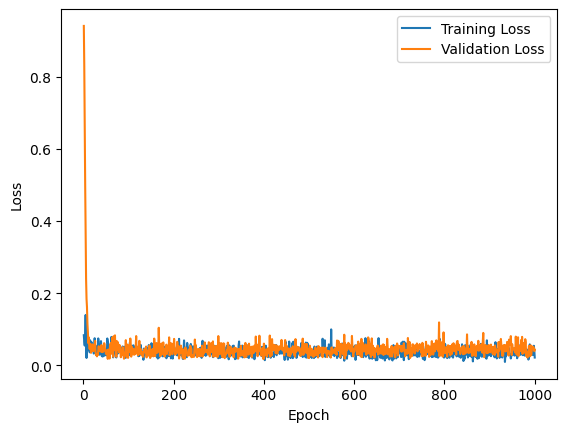

In [19]:
# plot training and validation loss
ticks = range(1, len(history.history["loss"]) + 1)
plt.plot(ticks, history.history["loss"], label="Training Loss")
plt.plot(ticks, history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Kernel Inception Distance

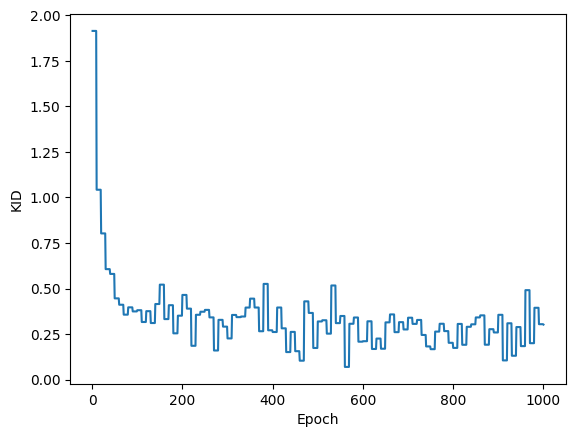

In [20]:
ticks = range(1, len(history.history["val_kid"]) + 1)
plt.plot(ticks, history.history["val_kid"])
plt.xlabel("Epoch")
plt.ylabel("KID")
plt.show()

## Generate random images

In [ ]:
model.load_weights("u_net.h5")

In [21]:
def reconstruct_images(image_count=5, t=50): # apply noise to images and denoise them to test reconstruction capability
    original_images = next(iter(val_ds.unbatch().batch(image_count))) # get images from the validation dataset
    noisy_images = [
        diffusion.q_sample(tf.expand_dims(img, 0), tf.constant([t])) # apply t timesteps of noise to each image
        for img in original_images
    ]
    reconstructed_images = [
        diffusion.p_sample_full(model, (1, IMAGE_SIZE, IMAGE_SIZE, 3), img, t)[-1] # denoise each image
        for img in noisy_images
    ]

    plt.figure(figsize=(2 * image_count, 2 * 3))
    for i in range(image_count):
        # Noisy versions in the first row
        plt.subplot(3, image_count, i + 0 * image_count + 1)
        plt.imshow(tf.squeeze(reverse_transform(noisy_images[i])))
        plt.title("Noisy")
        plt.axis("off")

        # Reconstructed versions in the second row
        plt.subplot(3, image_count, i + 1 * image_count + 1)
        plt.imshow(tf.squeeze(reverse_transform(reconstructed_images[i])))
        plt.title("Reconstructed")
        plt.axis("off")

        # Original versions in the third row
        plt.subplot(3, image_count, i + 2 * image_count + 1)
        plt.imshow(reverse_transform(original_images[i]))
        plt.title("Original")
        plt.axis("off")

    plt.show()

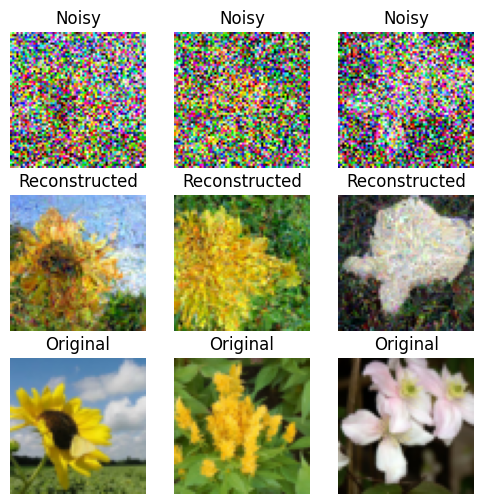

In [22]:
reconstruct_images(3, 300) # reconstruct 3 images with 300 applied noise levels

In [23]:
def generate_images(num_rows=4, num_cols=8, figsize=(12, 5)): # generate multiple images
    generated_samples = diffusion.generate_images(model, num_rows * num_cols)[-1]
    generated_samples = reverse_transform(generated_samples) # reverse the normalization of generated images
    _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i, image in enumerate(generated_samples):
        if num_rows == 1:
            ax[i].imshow(image)
            ax[i].axis("off")
        else:
            ax[i // num_cols, i % num_cols].imshow(image)
            ax[i // num_cols, i % num_cols].axis("off")
    plt.tight_layout()
    plt.show()

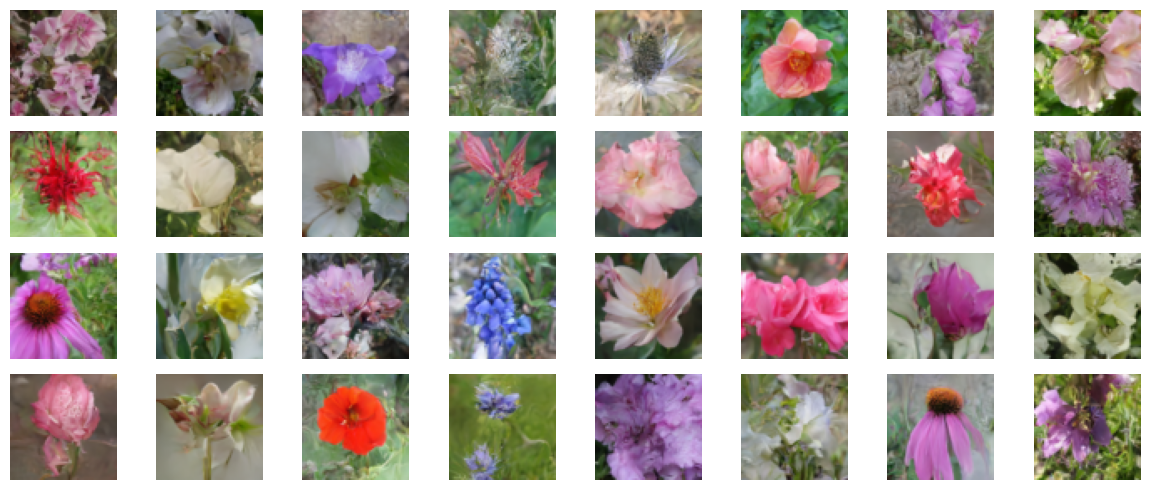

In [24]:
generate_images(4, 8) # generate 32 images

In [25]:
def generate_gif(filename="generated.gif", duration=4, fps=30):
    imgs = diffusion.generate_images(model, 1)
    imgs = [tf.squeeze(reverse_transform(img)) for img in imgs]
    imageio.mimsave(filename, imgs[::round(len(imgs)/(fps*duration))], fps=fps)
    display(Image(filename=filename, width=200, height=200))

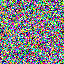

In [26]:
generate_gif()